## Figure S17-S21: MultiB Plot of Homogeneous Zones

In [5]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def custom_masker(mask_path, data_ds, model_id, metric_name='KGE'):
    """Mask an xarray dataarray"""
    dataarray = data_ds[f'{model_id}_{metric_name}'].squeeze()
    maskarray = xr.open_dataset(mask_path).mask.squeeze()
    
    if isinstance(maskarray, xr.DataArray):
        maskarray = maskarray.values
    if dataarray.shape != maskarray.shape:
        raise ValueError("dataarray and maskarray must have the same shape")
        
    masked_array = (dataarray * maskarray).data.flatten()
    masked_array = masked_array[~np.isnan(masked_array)]
    return masked_array

def plot_multibar(data_ds, data_dict, zones_dict, metric_name='KGE', metric_label='KGE', best_val_line=None, ylim=(None, None), 
                  show_legend=False, ax=None):
    # Load and mask data for each zone and model
    data_load = {zone: pd.DataFrame({model_label: custom_masker(zone_mask_path, data_ds, model_id, metric_name) 
                                     for model_id, model_label in data_dict.items()}) 
                 for zone, (zone_mask_path, zone_label) in zones_dict.items()}
    
    # Extract the data into a format suitable for boxplotting
    boxplot_data = []
    positions = []
    pos = 0
    zone_labels = []
    
    for zone in zones_dict.keys():
        for model in data_dict.keys():
            boxplot_data.append(data_load[zone][data_dict[model]])
            positions.append(pos)
            pos += 0.16
        zone_labels.append((positions[-len(data_dict)] + positions[-1]) / 2)  # Position the zone label in the middle of the models
        pos += 0.4  # Add extra space between different zones

    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 4))
        
    # Define colors for each model
    # colors = plt.get_cmap('tab10', len(data_dict))
    # colors = ["#ffbb78","#dbdb8d","#98df8a","#f7b6d2","#c49c94","#c5b0d5","#9edae5","#aec7e8","#2F4F4F"]

    colors = [
        "#ff7f0e",  # Orange pair
        "#bcbd22",  # Yellow-green pair
        "#2ca02c",  # Green pair
        "#e377c2",  # Pink pair
        "#8c564b",  # Brown pair
        "#9467bd",  # Purple pair
        "#17becf",  # Teal pair
        "#1f77b4",  # Blue pair
        "#2F4F4F",
    ]

    # Shade background for intermittent x-tick groups
    for i in range(0, len(positions), len(data_dict)):
        start_pos = positions[i] - 0.08
        end_pos = positions[i + len(data_dict) - 1] + 0.08
        ax.axvspan(start_pos, end_pos, color='lightgrey', alpha=0.3)
    
    # Create the boxplots
    for i, (data, position) in enumerate(zip(boxplot_data, positions)):
        ax.boxplot(data, positions=[position], showfliers=False, widths=0.15, patch_artist=True,
                   showmeans=True,
                   boxprops=dict(facecolor=colors[i % len(data_dict)], color=colors[i % len(data_dict)]),
                   capprops=dict(color=colors[i % len(data_dict)]),
                   whiskerprops=dict(visible=True,  linestyle='--', alpha=0.5),
                   flierprops=dict(markeredgecolor=colors[i % len(data_dict)]),
                   medianprops=dict(color='black'),
                   meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor=colors[i % len(data_dict)]))

    
    # Customize the plot
    ax.set_ylabel(metric_label, fontsize=20, fontweight="semibold")
    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='x', labelsize=24)
    ax.set_ylim(ylim[0], ylim[1])
    
    # Set x-ticks and labels
    ax.set_xticks(zone_labels)
    ax.set_xticklabels(zones_dict.keys(), rotation=0, fontsize=28, fontweight='bold')
    ax.set_ylabel(metric_label, fontsize=28, fontweight='bold')
    
    # Add a legend for the models
    handles = [plt.Line2D([0], [0], color=colors[i], marker='s', markersize=10, markerfacecolor=colors[i], 
                          label=model) for i, model in enumerate(data_dict.values())]

    if show_legend:
        ax.legend(handles=handles, loc='upper center', fontsize=28, ncol=3, bbox_to_anchor=(0.5, -0.21))
    if best_val_line is not None:
        ax.axhline(y=best_val_line, color='k', linestyle='--', alpha=0.3)

#######################################################################################################################

def plot_figure_S17_21(idc, expname, fignum, savefig):
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
    
    MASK_PATH = '/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/MASKFILES'
    zones_dict = {
         # 'IND': [f'{MASK_PATH}/India.nc', 'INDIA'], 
        'MCZ': [f'{MASK_PATH}/Monsoon_Core_Zone.nc', 'MONSOON CORE ZONE'], 
        'WG' : [f'{MASK_PATH}/Western_Ghats.nc' , 'WESTERN GHATS'],
        'NE' : [f'{MASK_PATH}/Northeast.nc' , 'NORTHEAST'], 
        'SP' : [f'{MASK_PATH}/South_Peninsular.nc' , 'SOUTHERN PENINSULA'], 
        'CNE': [f'{MASK_PATH}/Central_Northeast.nc', 'CENTRAL NORTHEAST'],   
        'WC' : [f'{MASK_PATH}/West_Central.nc' , 'WEST CENTRAL'], 
        'NW' : [f'{MASK_PATH}/Northwest.nc' , 'NORTHWEST'], 
    }

    
    index_dict = {

        f'N01_{idc}': 	f'DENSE-{expname}', 
        f'N02_{idc}': 	f'CNN-{expname}', 
        f'N03_{idc}': 	f'FSRCNN-{expname}',  
        f'S01_{idc}': 	f'SRDRN1-{expname}', 
        f'S02_{idc}': 	f'SRDRN2-{expname}', 
        f'S03_{idc}': 	f'SRDRN3-{expname}',  
        f'U01_{idc}': 	f'UNET-{expname}', 
        f'U02_{idc}': 	f'XNET-{expname}', 
        'C01'        :  'BCSD',
    }
    
    
    data_ds = xr.open_dataset('/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/EVAL_METRICS_SPATIAL_v1.nc')
    
    # Plotting
    plot_multibar(data_ds, index_dict, zones_dict, metric_name='PCC', metric_label='PCC', best_val_line=1, ylim=(0.28, 1), show_legend=False, ax=axs[0])
    plot_multibar(data_ds, index_dict, zones_dict, metric_name='NSE', metric_label='NSE', best_val_line=1, ylim=(-0.4, 1), show_legend=False, ax=axs[1])
    plot_multibar(data_ds, index_dict, zones_dict, metric_name='PBIAS', metric_label='PBIAS(%)',  best_val_line=0, ylim=(-90, 90), show_legend=True, ax=axs[2])
    
    # Add labels for each subplot
    mark_list = ['(a)', '(b)', '(c)']
    for i, mark in enumerate(mark_list):
        axs[i].text(0.483, 0.9, mark, transform=axs[i].transAxes, fontsize=30, color='k', fontweight='bold')
    
    # Adjust layout
    plt.tight_layout(h_pad=2)

    if savefig:
        SAVE_PATH = "/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/RESULTS"
        plt.savefig(f'{SAVE_PATH}/Figure{fignum}_MultiBox_Plot_Zones.png', 
                    format='png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='w')
    
    plt.show()

### Plot Below

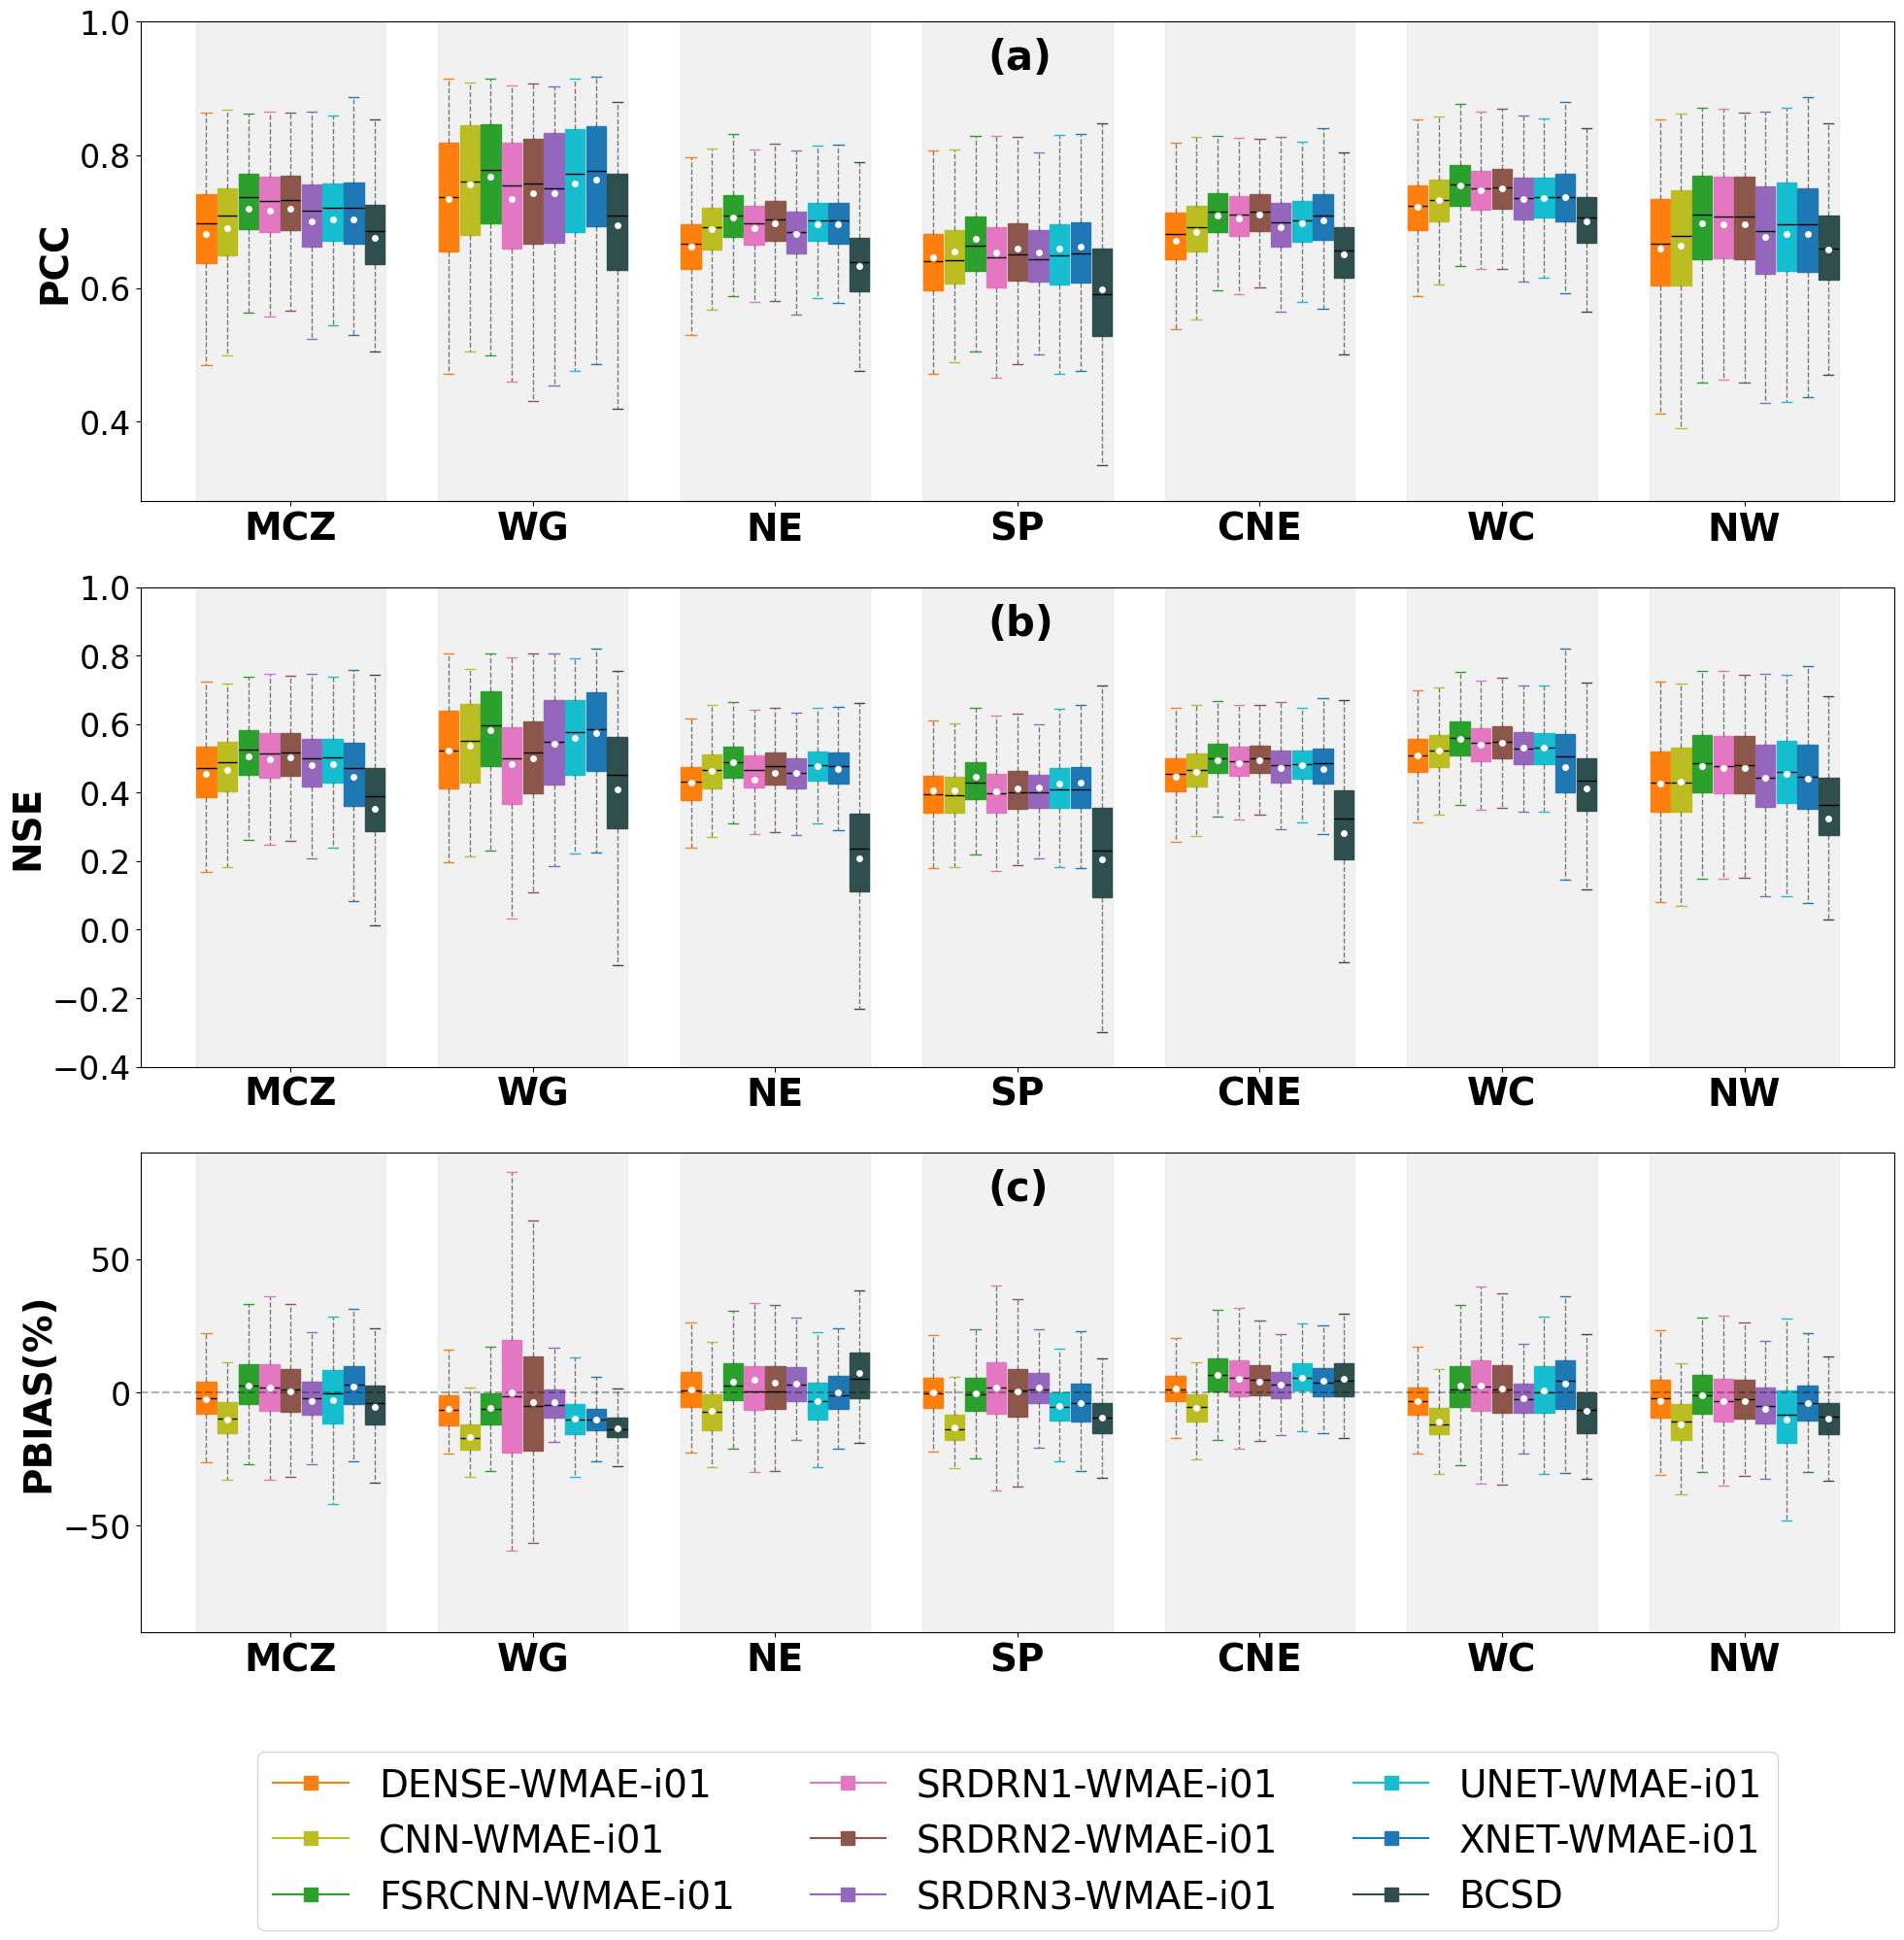

In [8]:
plot_figure_S17_21(idc="L01_I01", expname="WMAE-i01", fignum="S17", savefig=True)

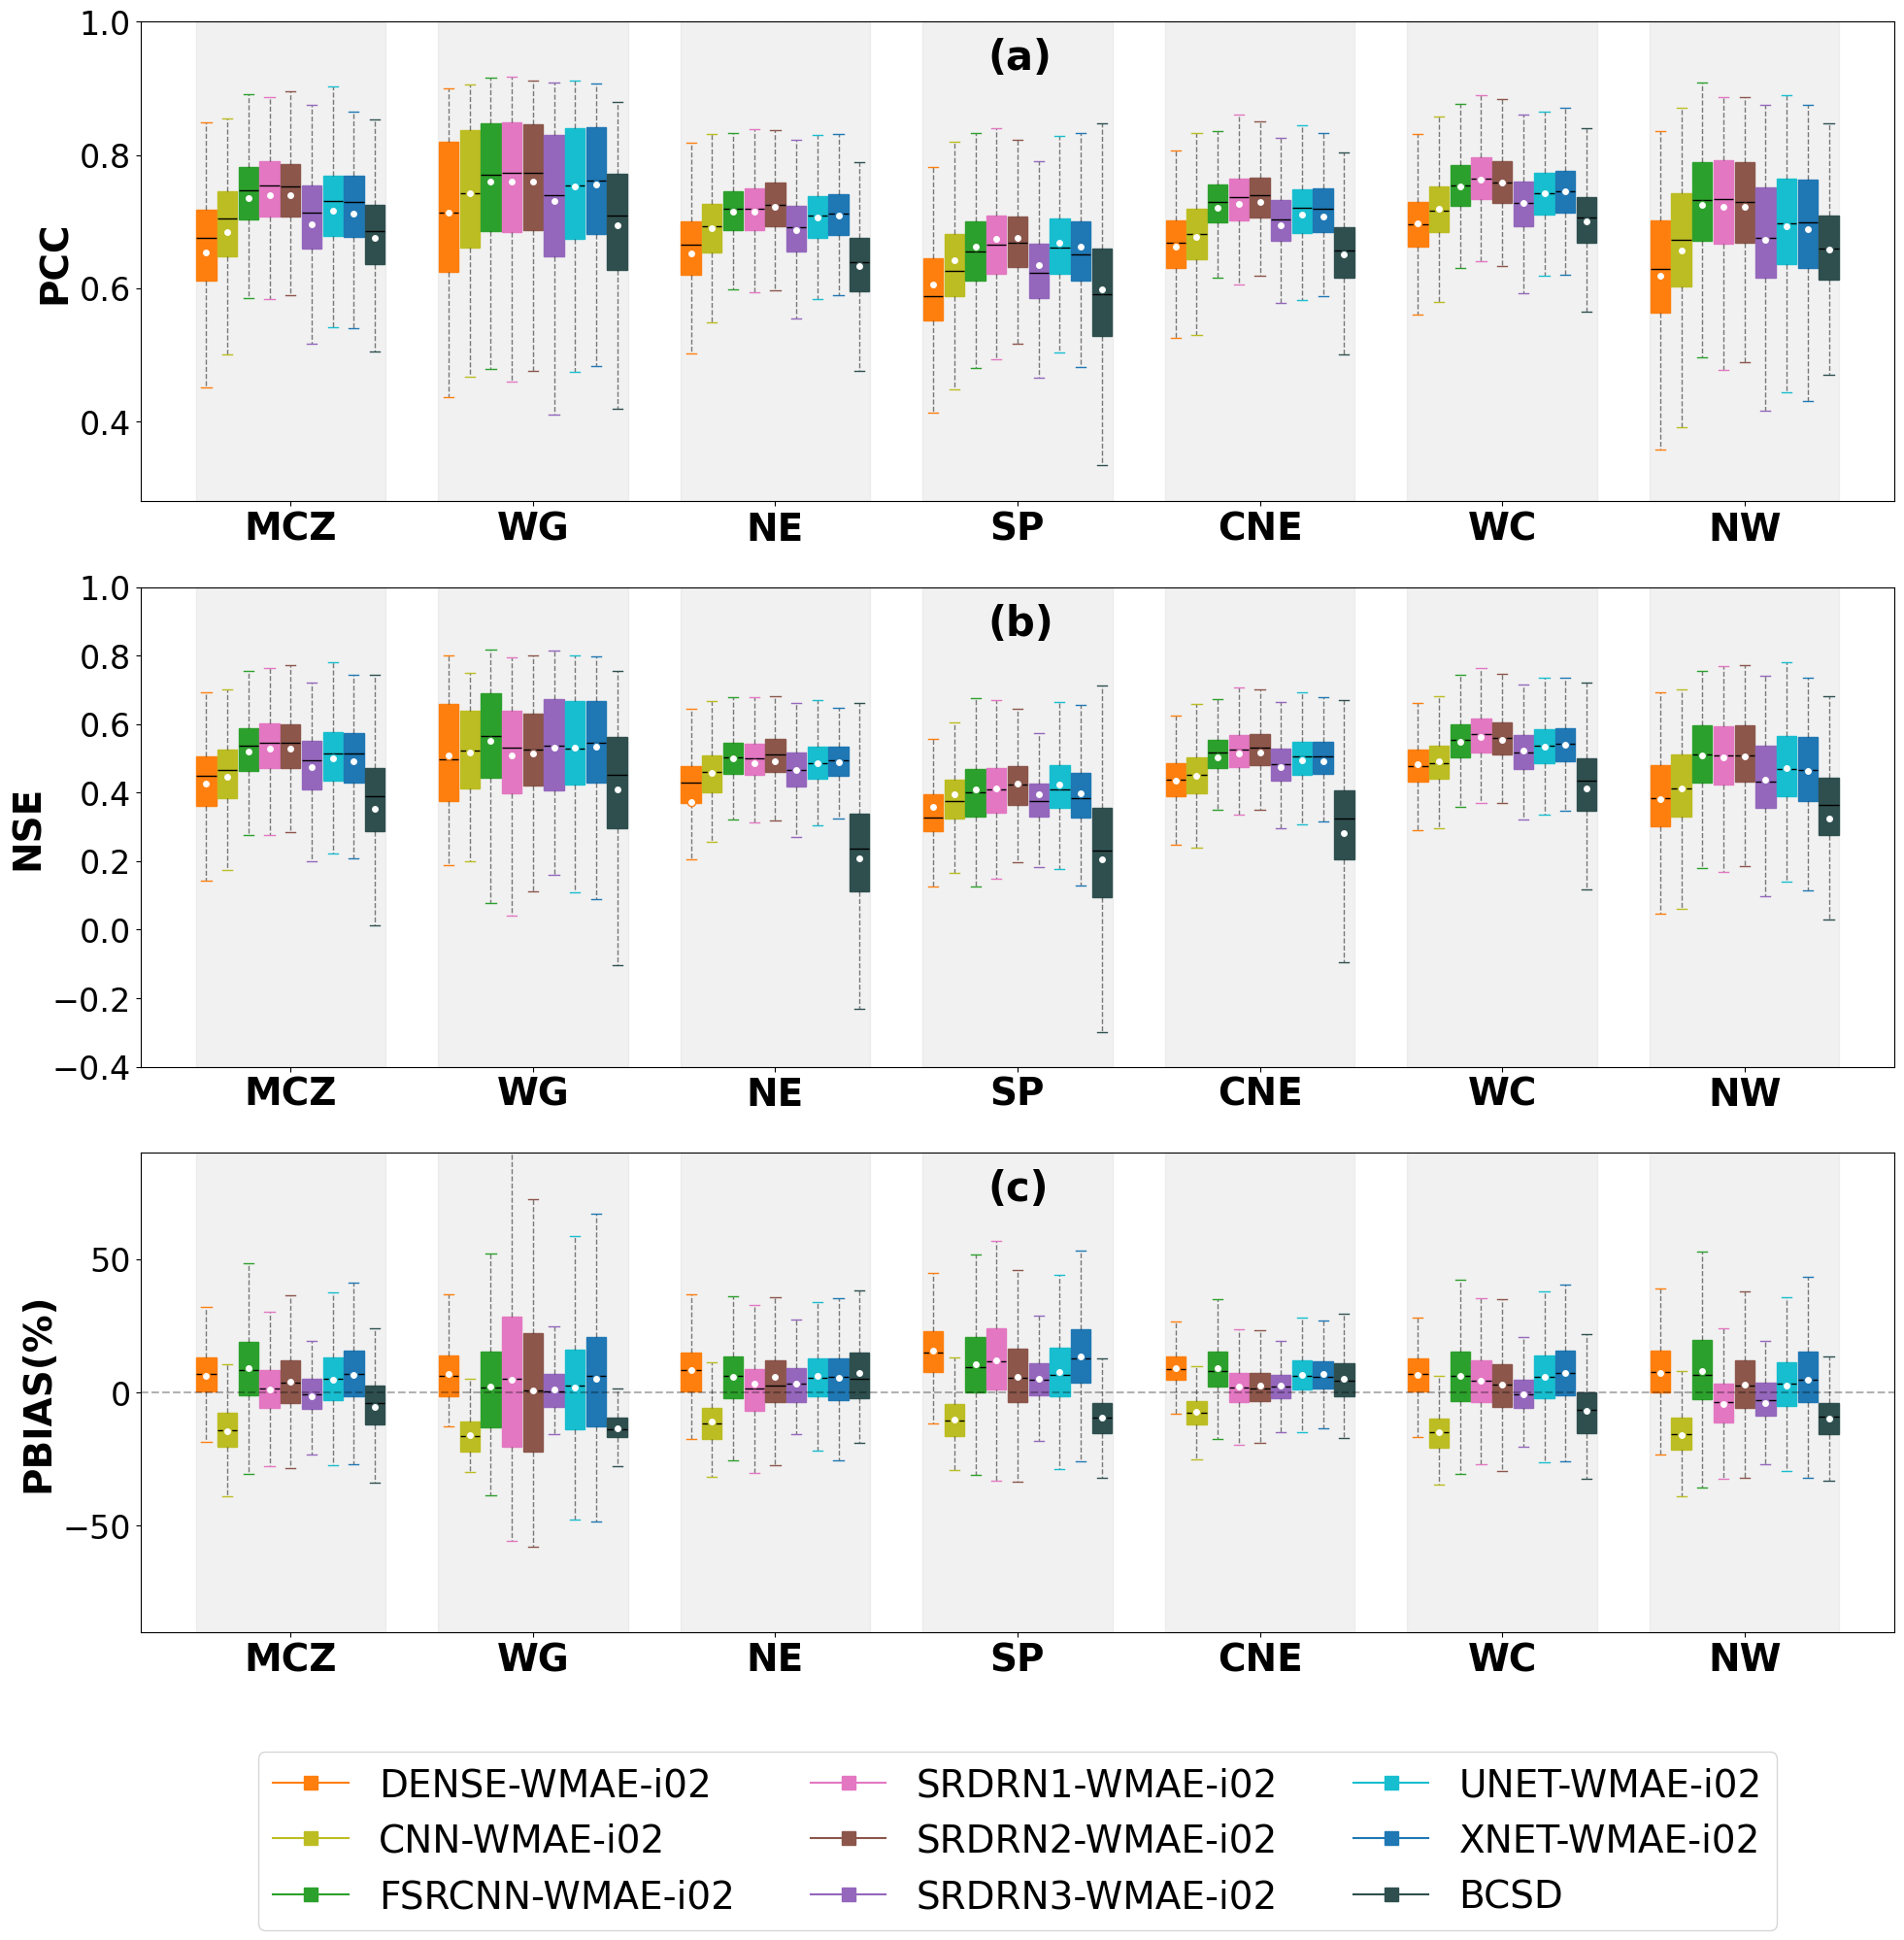

In [9]:
plot_figure_S17_21(idc="L01_I02", expname="WMAE-i02", fignum="S18", savefig=True)

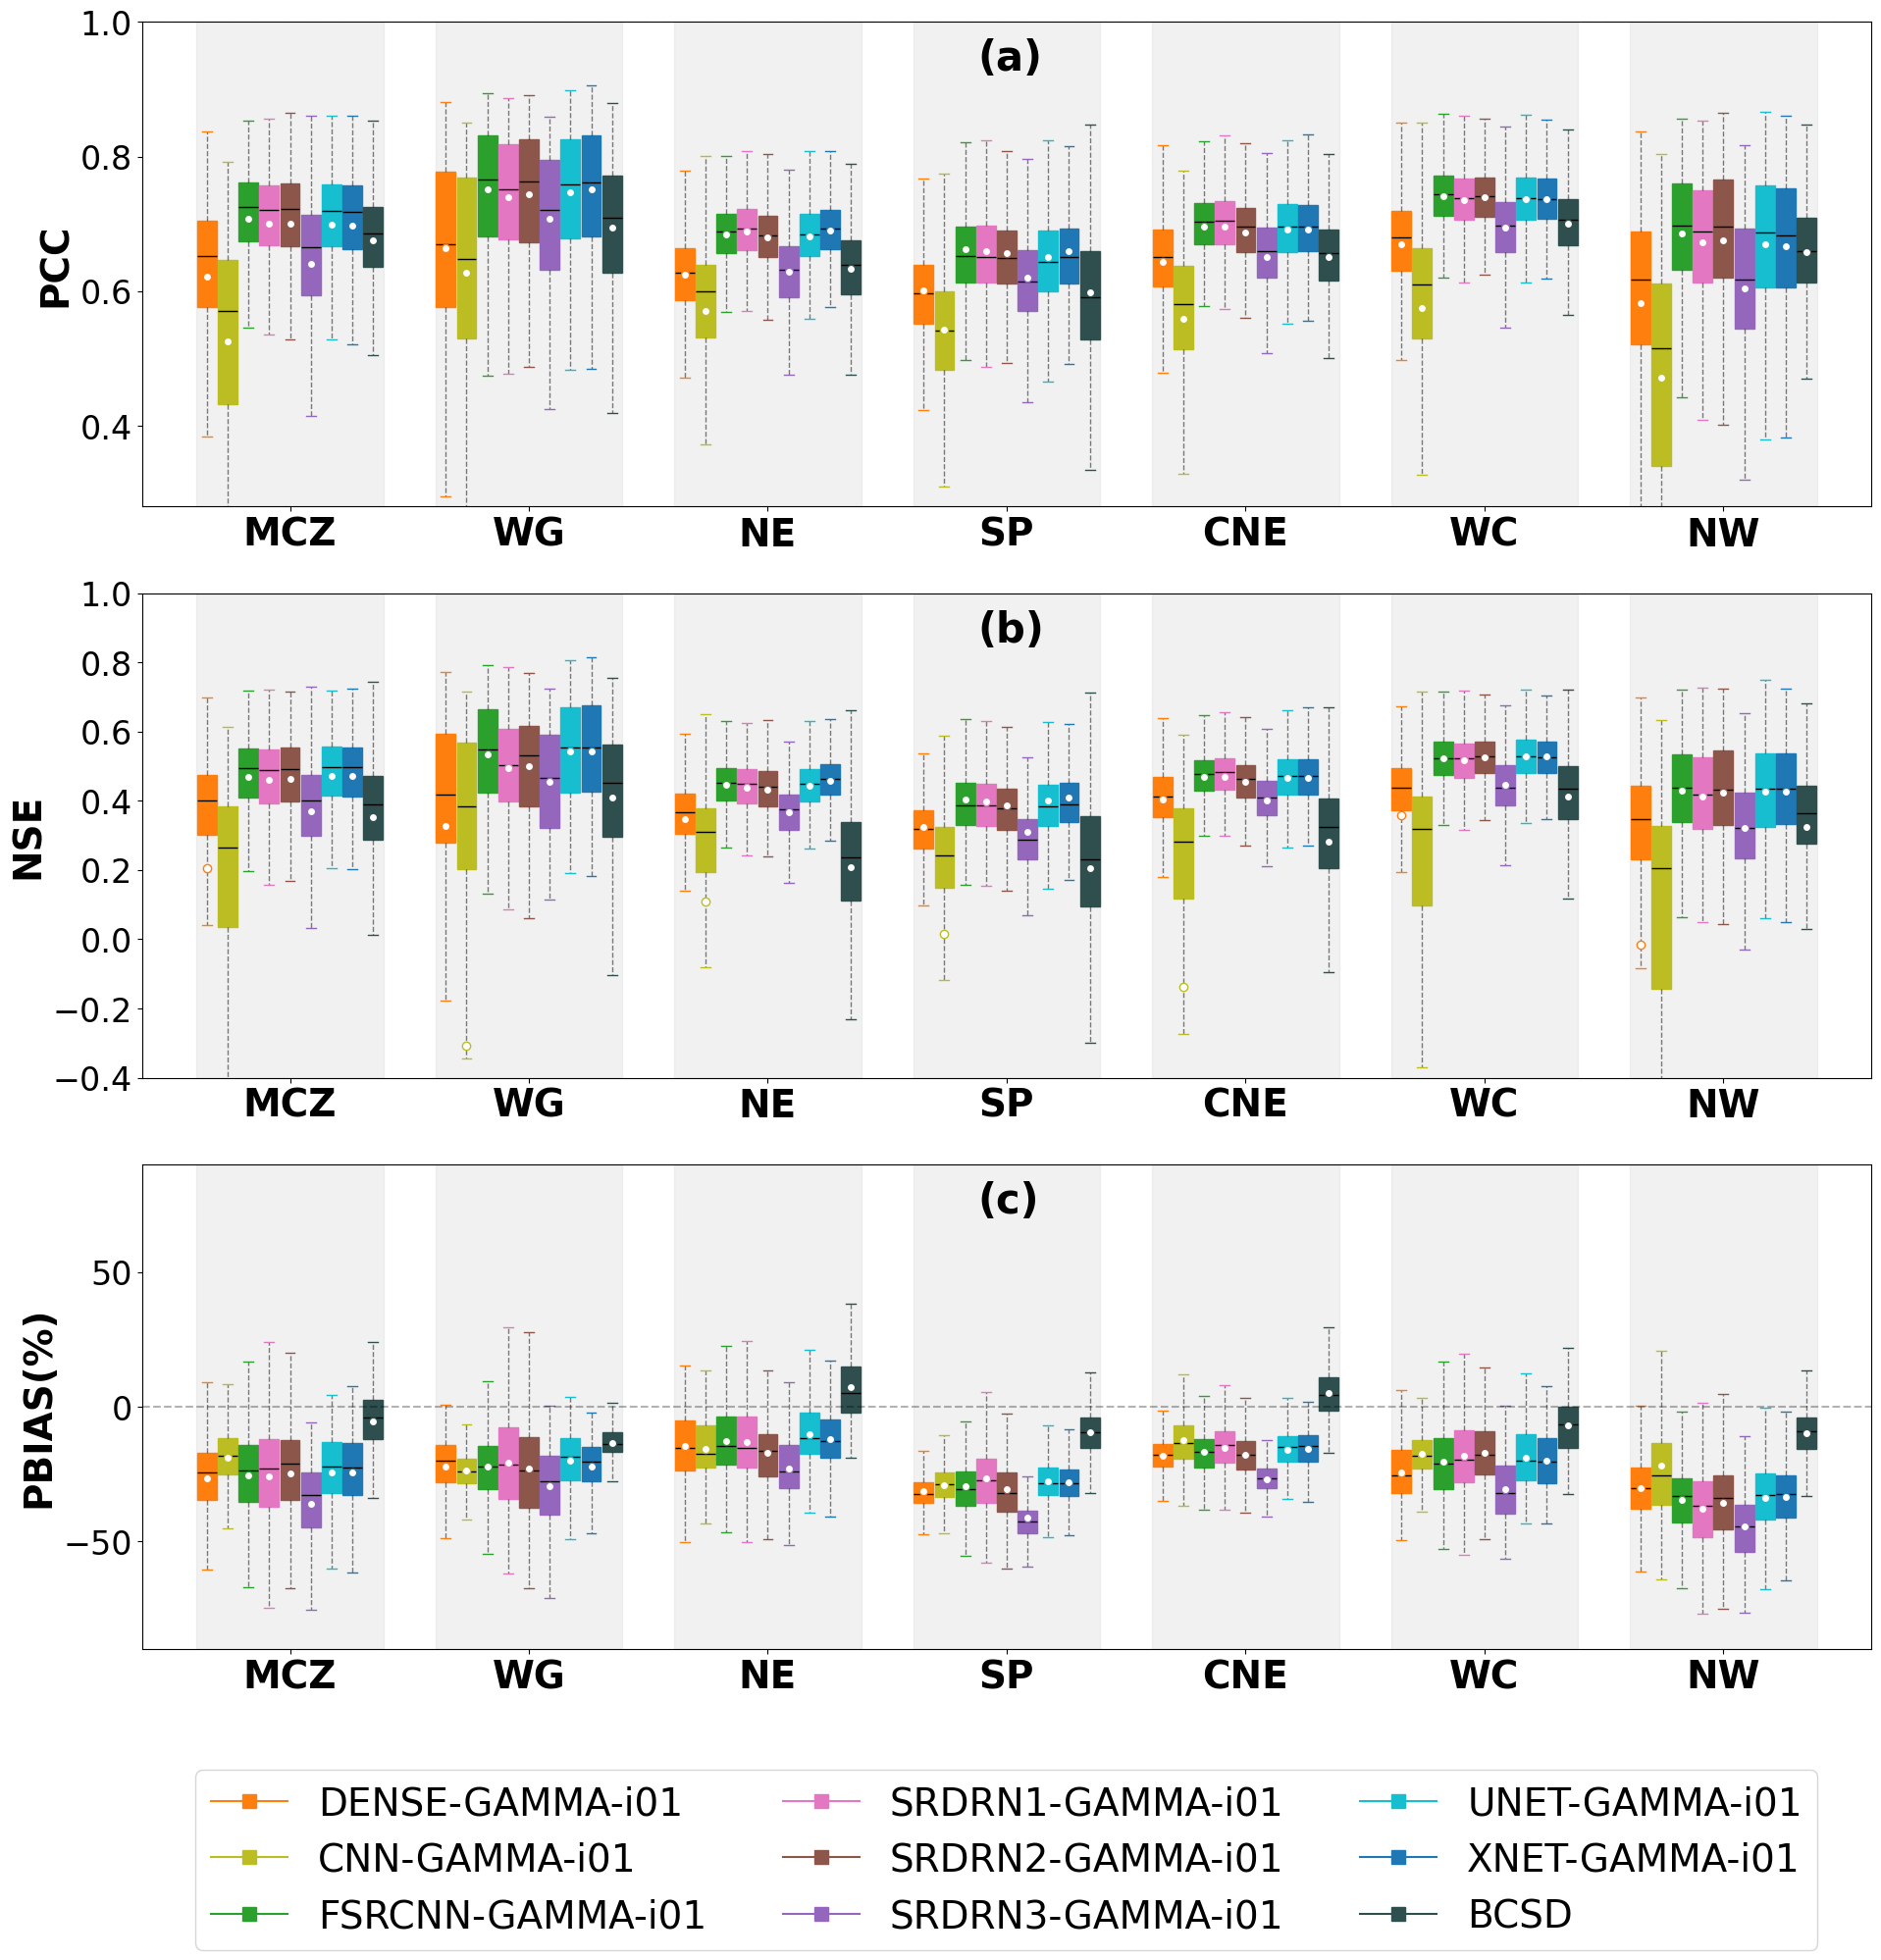

In [10]:
plot_figure_S17_21(idc="L02_I01", expname="GAMMA-i01", fignum="S19", savefig=True)

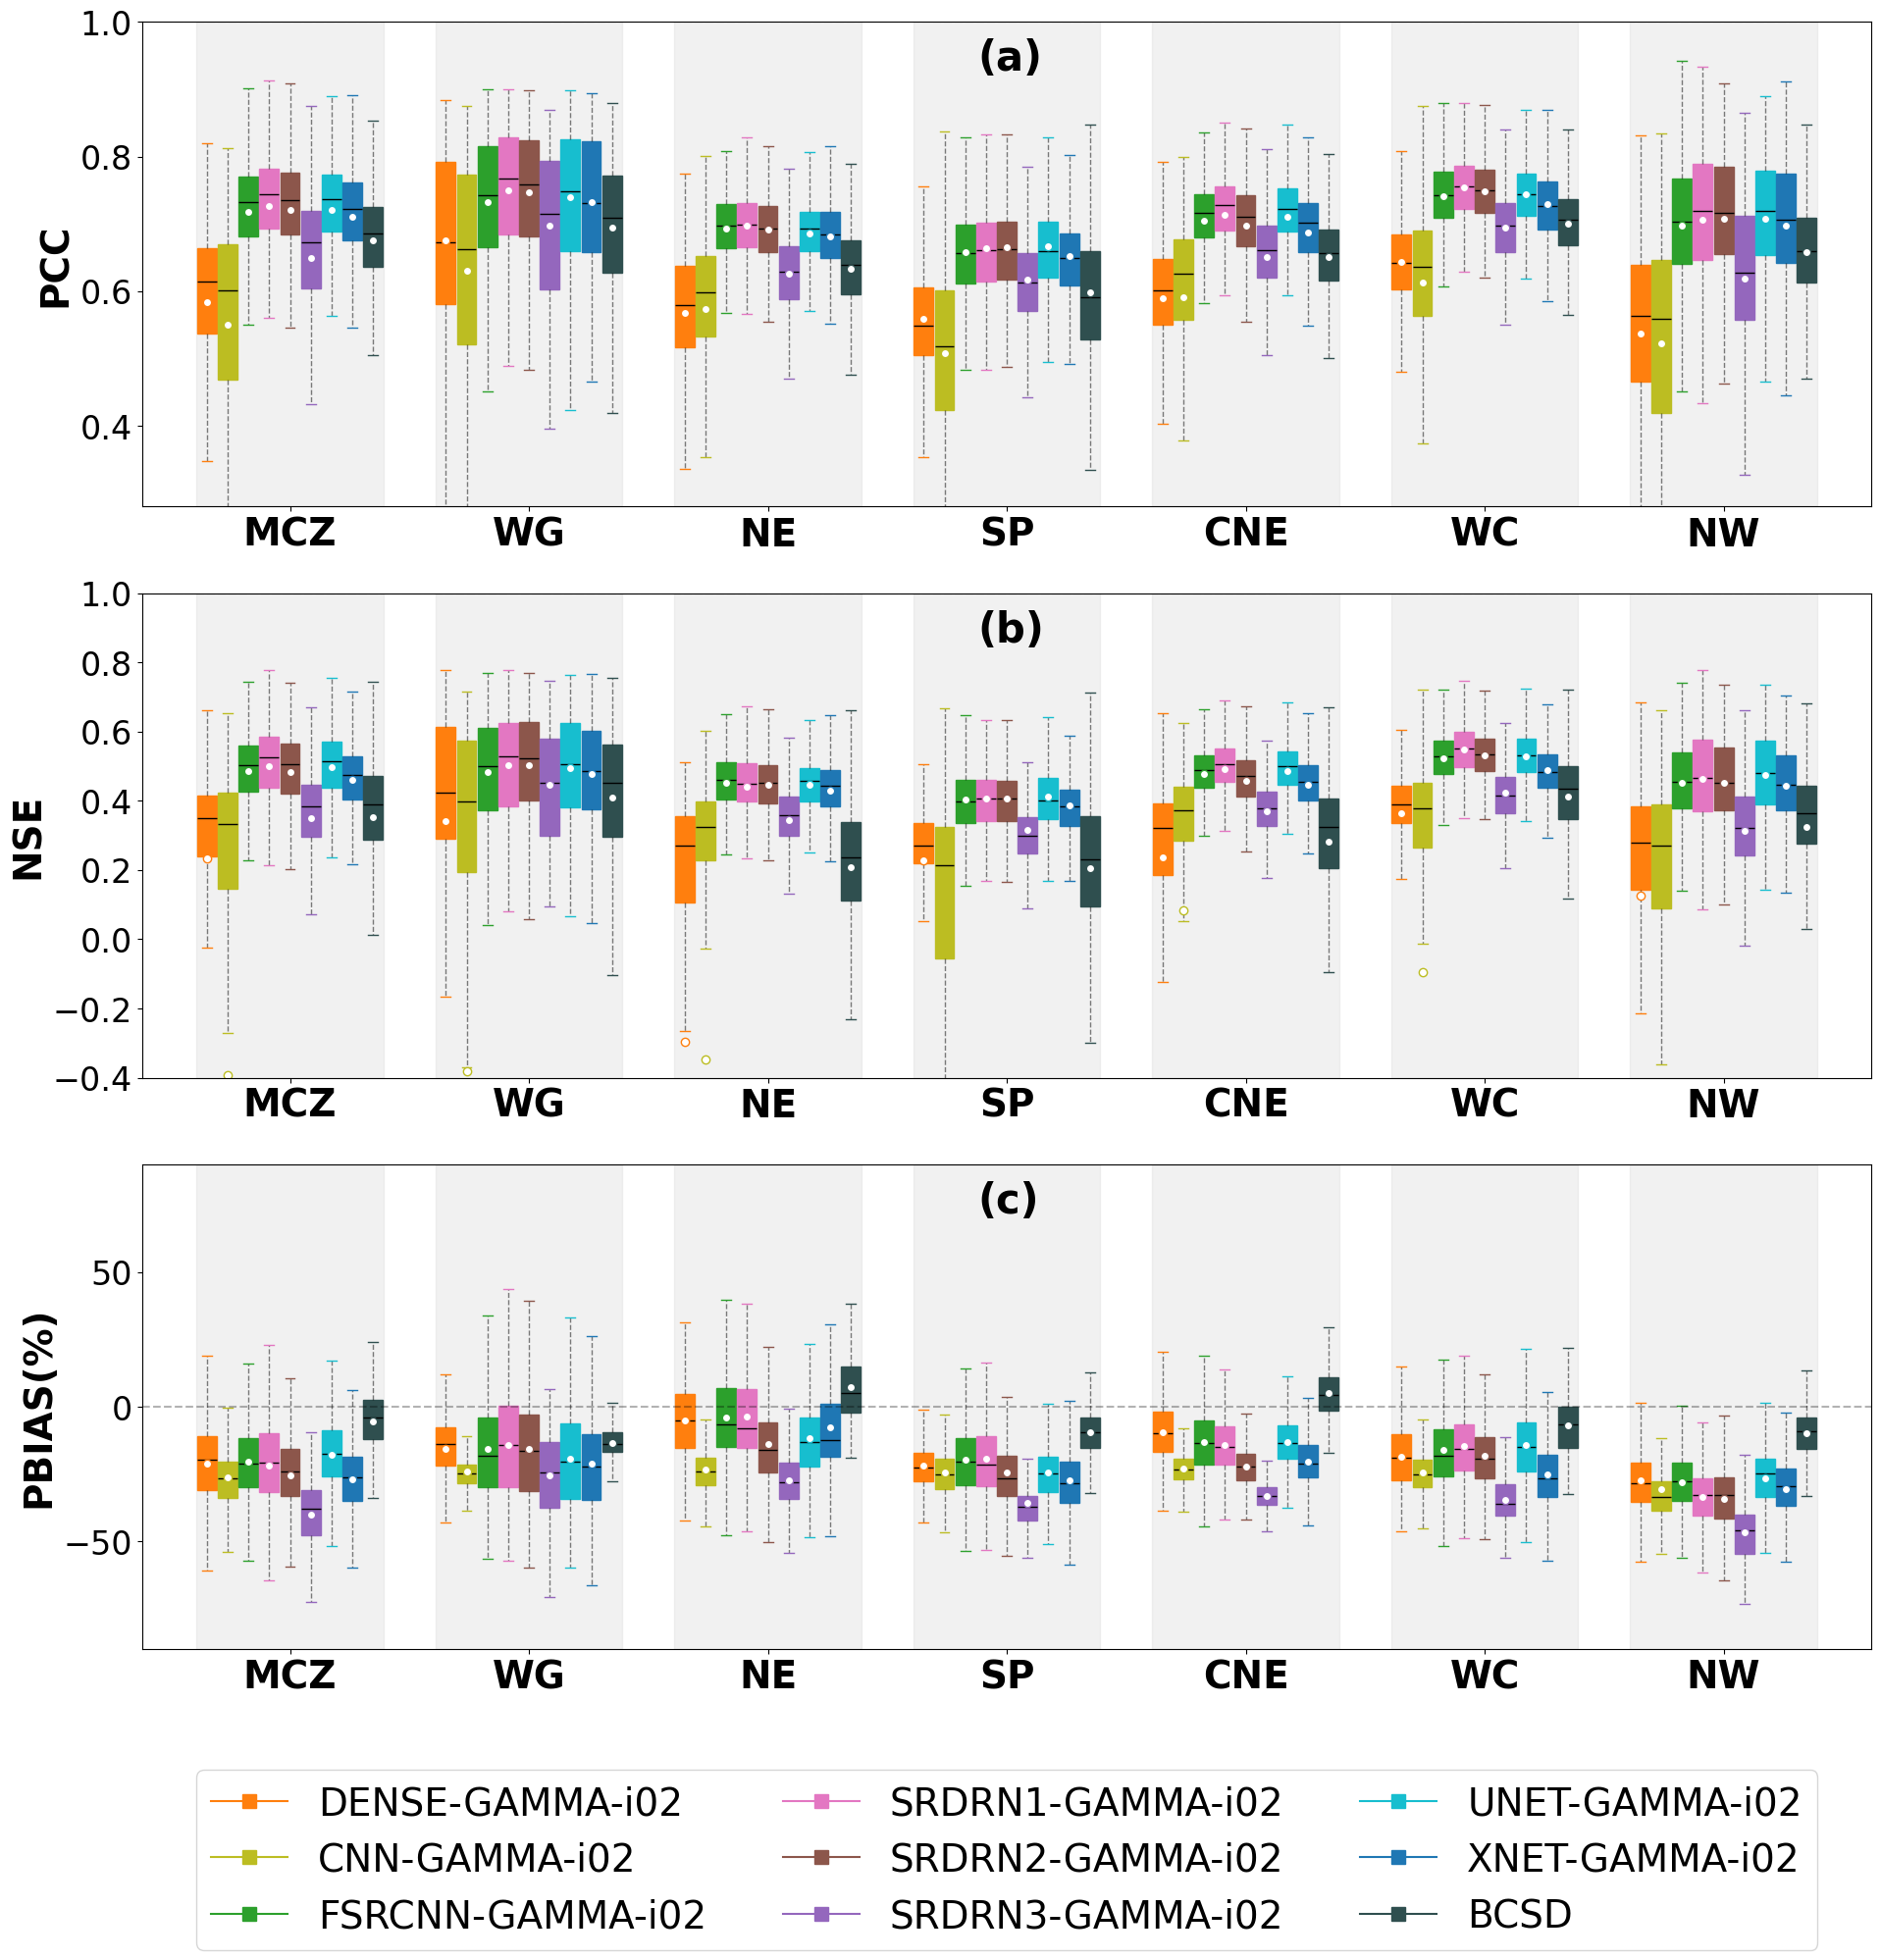

In [11]:
plot_figure_S17_21(idc="L02_I02", expname="GAMMA-i02", fignum="S20", savefig=True)

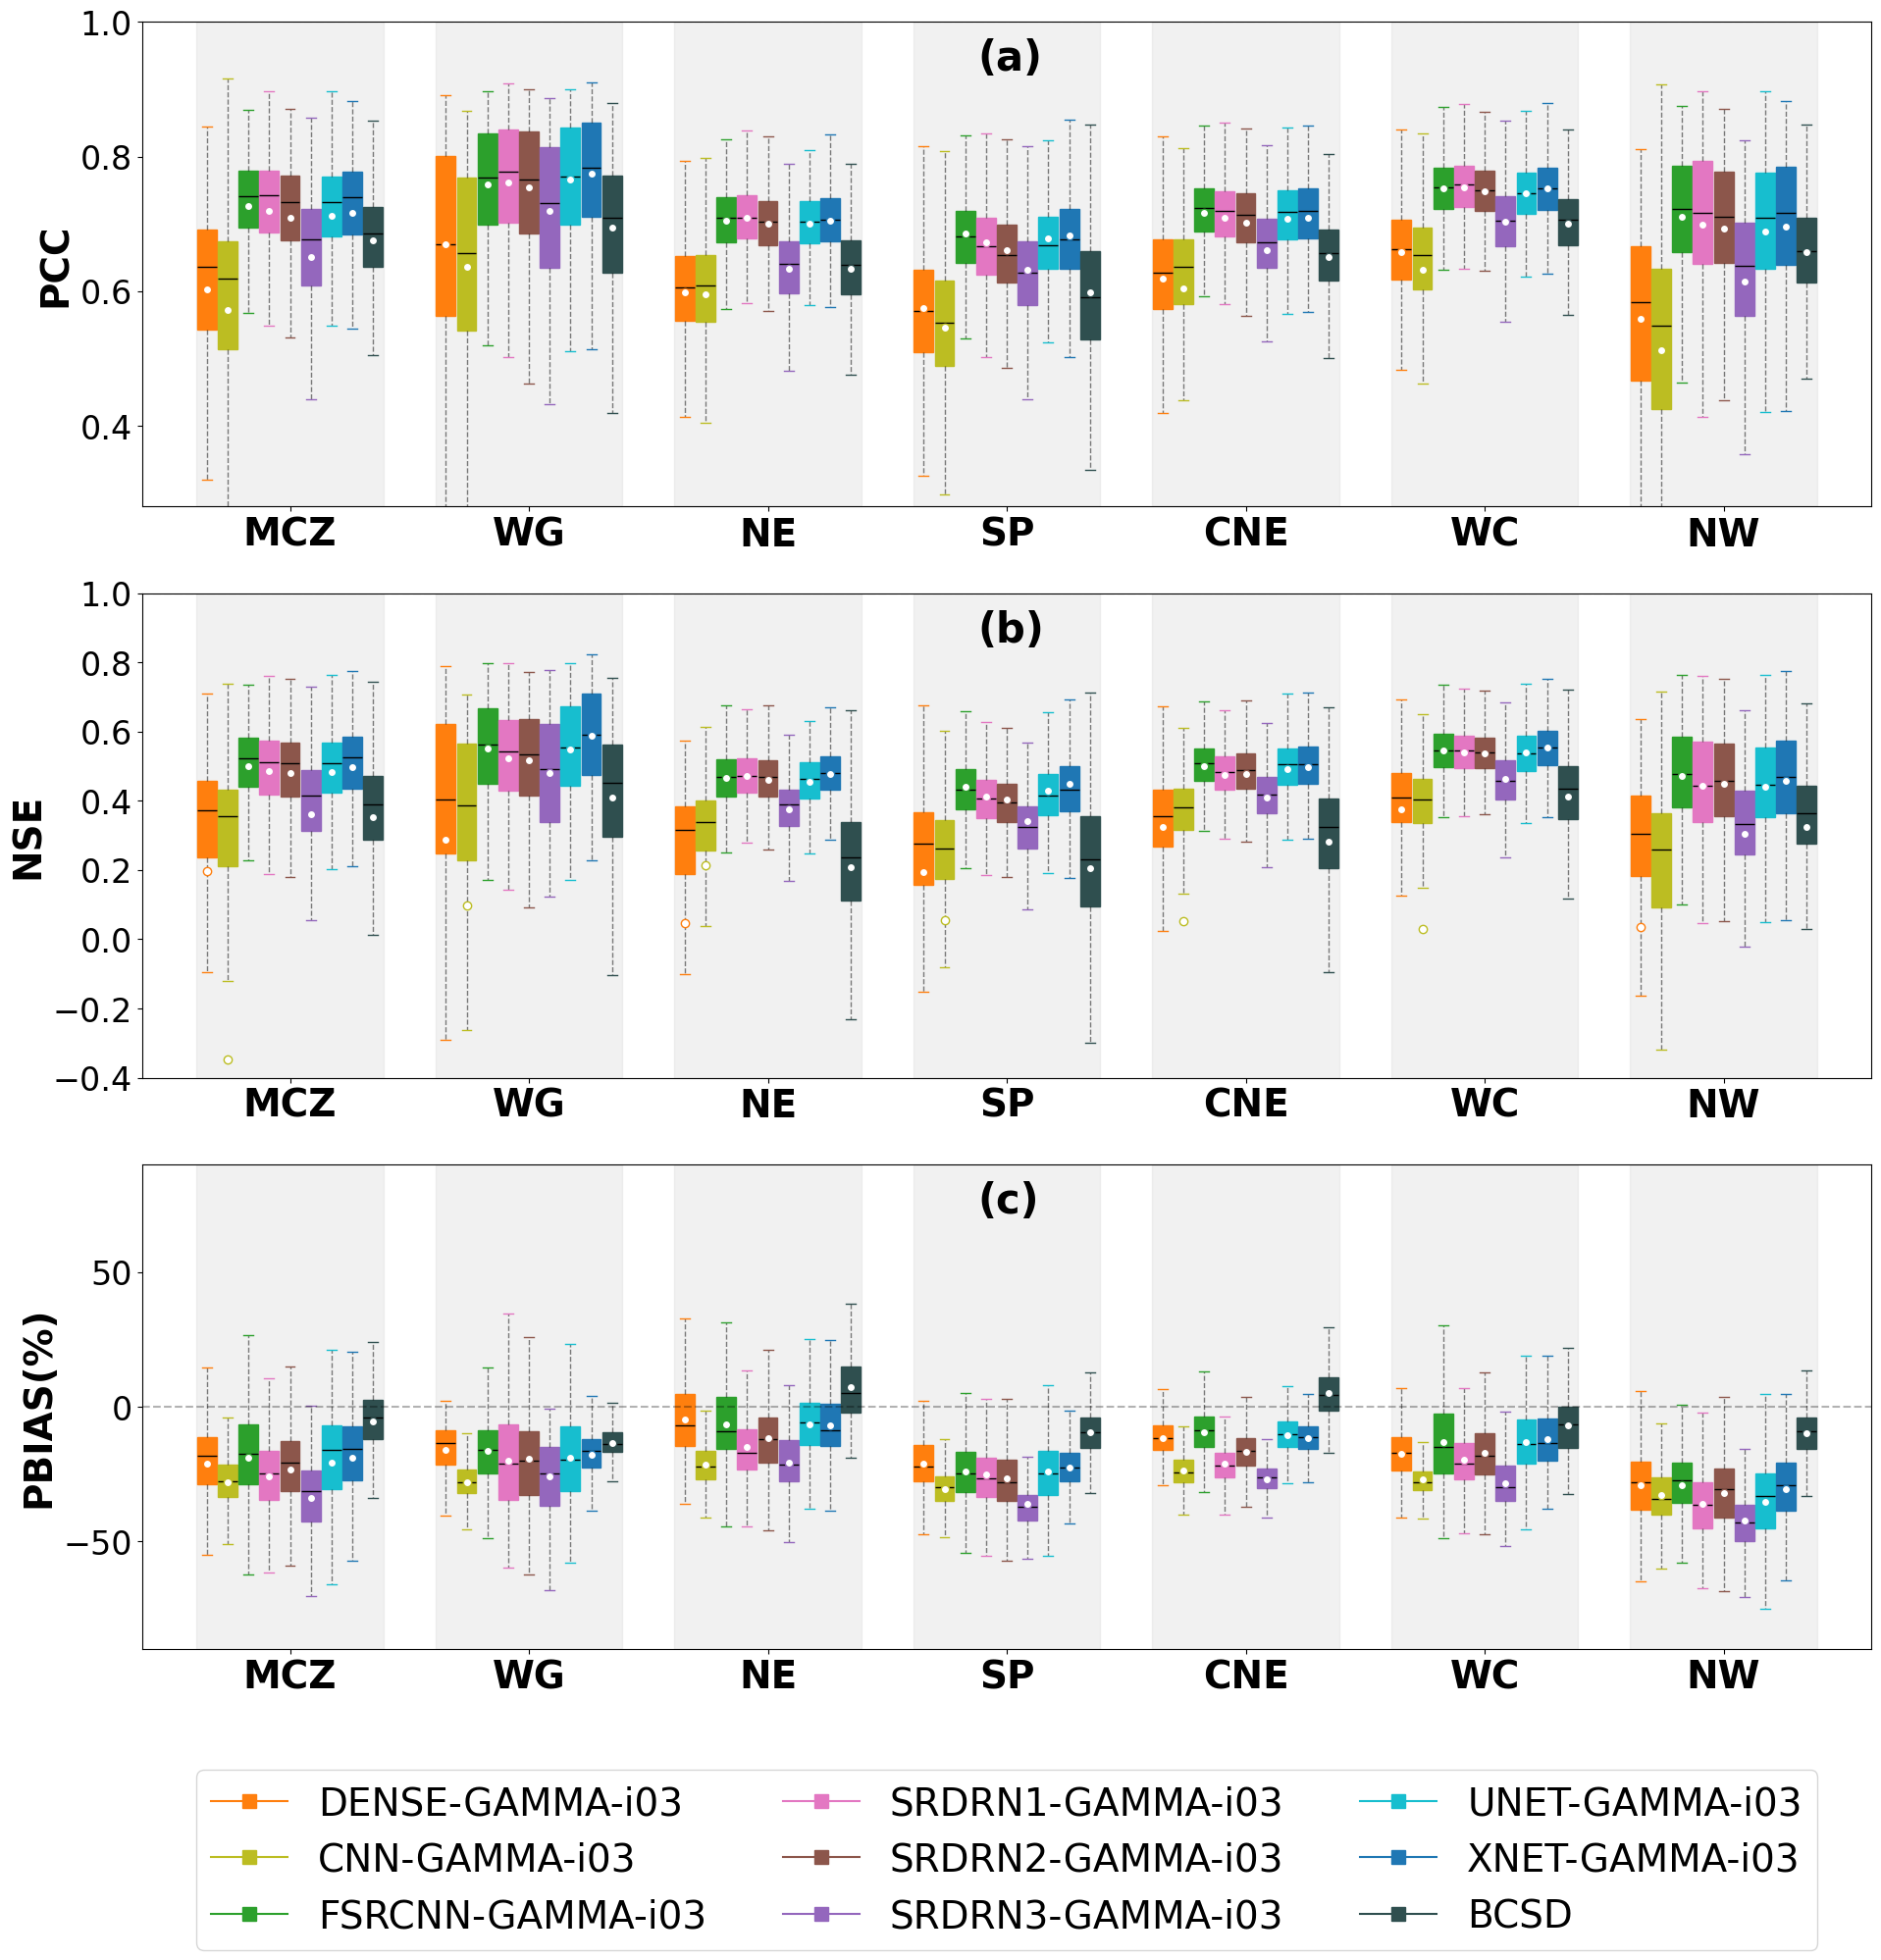

In [12]:
plot_figure_S17_21(idc="L02_I03", expname="GAMMA-i03", fignum="S21", savefig=True)

## Figure S22-S26: MultiBar Plot of Homogeneous Zones + Seasons

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_df(df, column, string):
    """Select and merge rows from the dataframe where the specified string is present in the specified column."""
    return df[df[column].str.contains(string, na=False)]

def plot_figure_S22_26(expname="GAMMA-i03", fignum="S21", savefig=True):
    # Read the data
    df = pd.read_csv('/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/TABLE_EVALMETRICS_wSEASZONE_v1.0.0.csv')
    
    # Define regions and seasons
    regions = ['IND', 'MCZ', 'WG', 'SP',  'CNE', 'NE', 'WC', 'NW']
    regions_names = [
        'INDIA', 
        'MONSOON CORE ZONE', 
        'WESTERN GHATS', 
        'SOUTHERN PENINSULA', 
        'CENTRAL NORTHEAST', 
        'NORTHEAST',
        'WEST CENTRAL', 
        'NORTHWEST'
    ]
    seasons = [ 'JJAS',  'ON', 'DJF', 'MAM',]
    0
    # Define methods (using i03 versions as per your data)
    methods = [
        f'DENSE-{expname}', 
        f'CNN-{expname}',
        f'FSRCNN-{expname}',
        f'SRDRN1-{expname}',
        f'SRDRN2-{expname}', 
        f'SRDRN3-{expname}',
        f'UNET-{expname}',
        f'XNET-{expname}',
        'BCSD',
        ]
    
    # Define colors
    colors = [
        "#ff7f0e",  # Orange pair
        "#bcbd22",  # Yellow-green pair
        "#2ca02c",  # Green pair
        "#e377c2",  # Pink pair
        "#8c564b",  # Brown pair
        "#9467bd",  # Purple pair
        "#17becf",  # Teal pair
        "#1f77b4",  # Blue pair
        "#2F4F4F",
    ]
    
    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(4, 2, figsize=(10, 9))
    fig.subplots_adjust(hspace=1, wspace=0.1)
    # fig.suptitle('PCC Scores by Region and Season', fontsize=16, fontweight='bold')
    
    bar_width = 0.5
    gap = 1
    metric = 'PCC'
    
    for idx, (region, region_name, ax) in enumerate(zip(regions, regions_names, axes.flat)):
        x = np.arange(len(seasons)) * (len(methods) * bar_width + gap)
        
        for j, method in enumerate(methods):
            season_values = []
            for season in seasons:
                value = df[(df['ZONE'] == region) & 
                          (df['SEASON'] == season) & 
                          (df['LABEL'] == method)][metric].values
                season_values.append(value[0] if len(value) > 0 else np.nan)
            
            ax.bar(x + j * bar_width, season_values, width=bar_width, 
                   color=colors[j], label=method if idx == 0 else "", zorder=1)
        
        # Customize subplot
        ax.set_title(f"({chr(97 + idx)})", loc='center', fontweight='bold', pad=12)
        ax.set_ylabel(metric, fontsize=14)
        ax.set_xticks(x + (len(methods) * bar_width) / 2 - bar_width / 2)
        ax.set_xticklabels(seasons)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_ylim(0, 1.0)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
        
        # Add subplot labels
        ax.text(0.05, 0.85, f"{region_name}", transform=ax.transAxes, 
                fontsize=12, fontweight='bold', fontfamily='sans-serif')
    
    # Add single legend at the bottom
    # fig.legend(methods, loc='center', fontsize=12, bbox_to_anchor=(1.12, 0.55), 
    #           ncol=1, frameon=False)
    
    fig.legend(methods, loc='center', fontsize=12, bbox_to_anchor=(0.5, 0.01), 
               ncol=3, frameon=False)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)

    if savefig:
        SAVE_PATH = "/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/RESULTS"
        plt.savefig(f'{SAVE_PATH}/Figure{fignum}_MultiBar_Plot_Zones_Season.png', 
                    format='png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='w')
    
    plt.show()

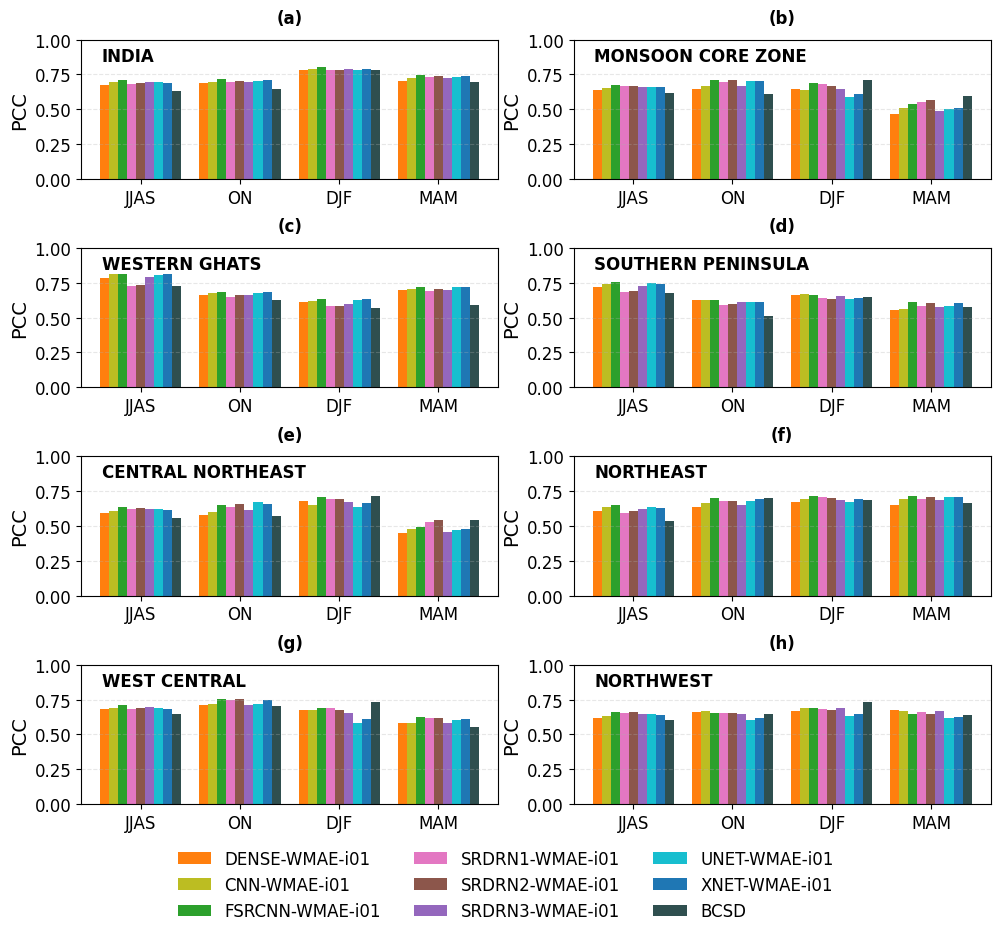

In [14]:
plot_figure_S22_26(expname="WMAE-i01", fignum="S22", savefig=True)

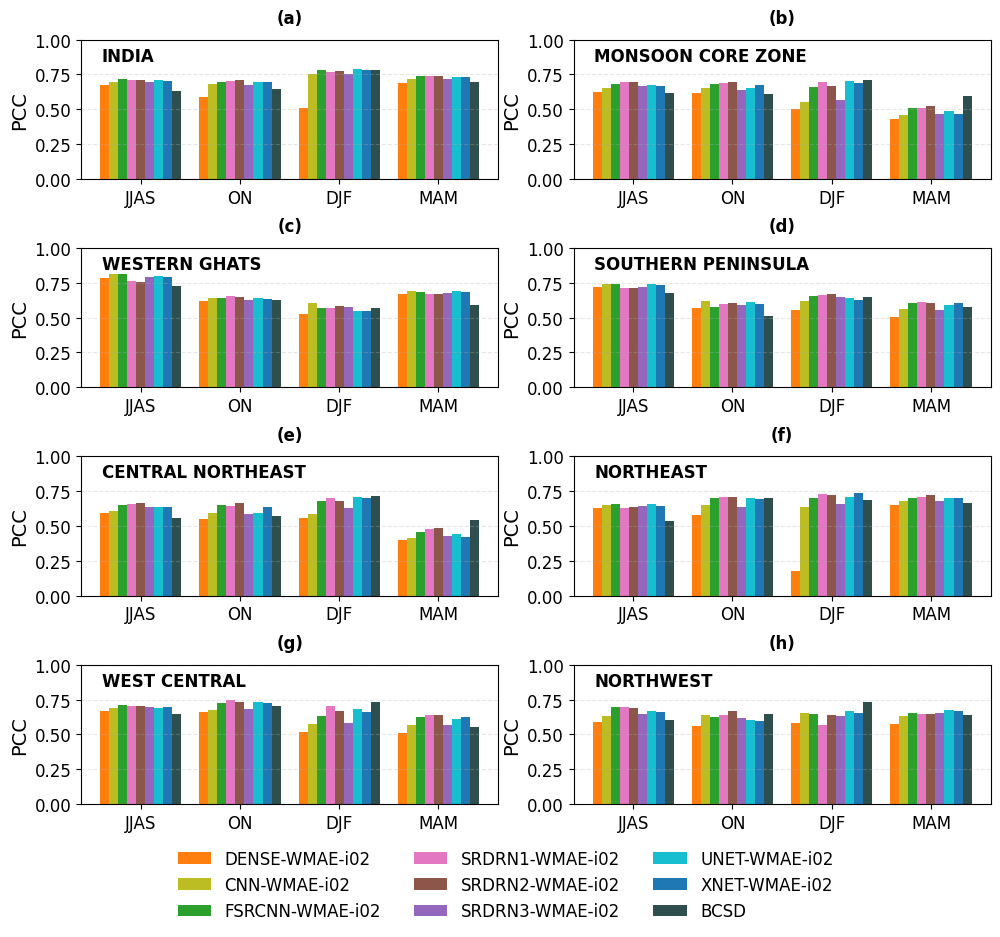

In [15]:
plot_figure_S22_26(expname="WMAE-i02", fignum="S23", savefig=True)

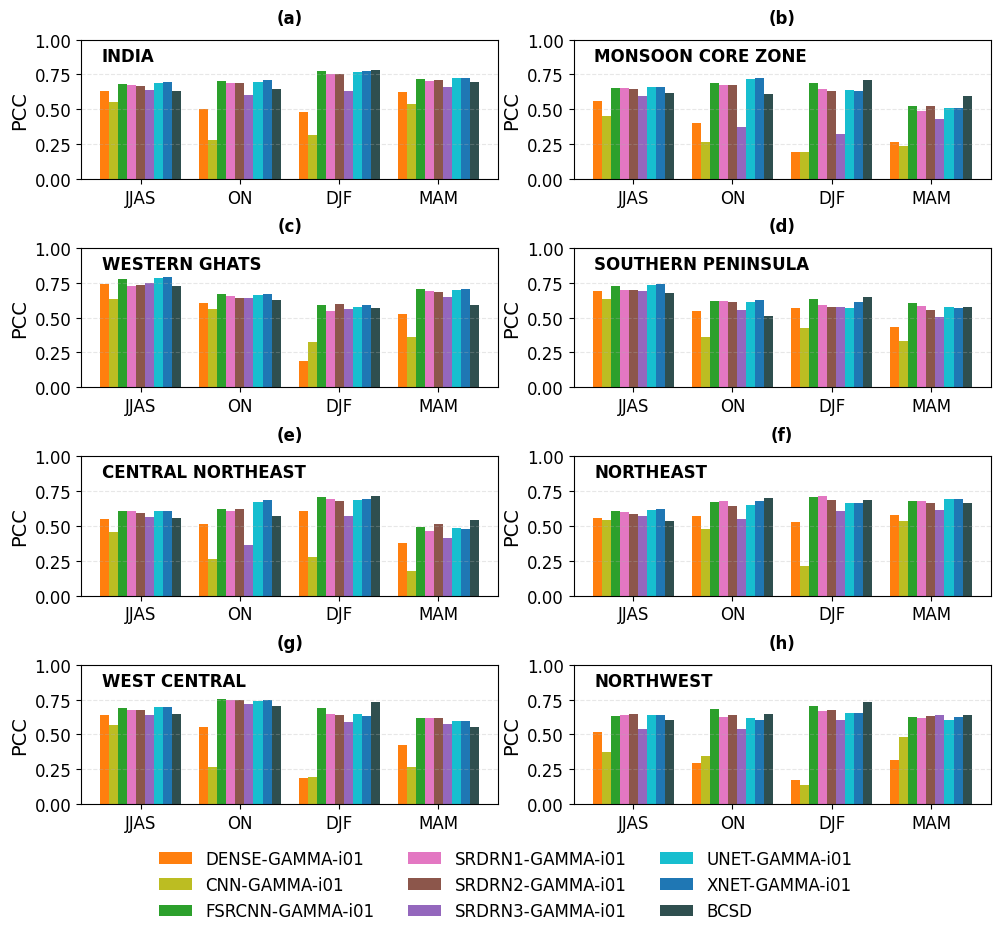

In [16]:
plot_figure_S22_26(expname="GAMMA-i01", fignum="S24", savefig=True)

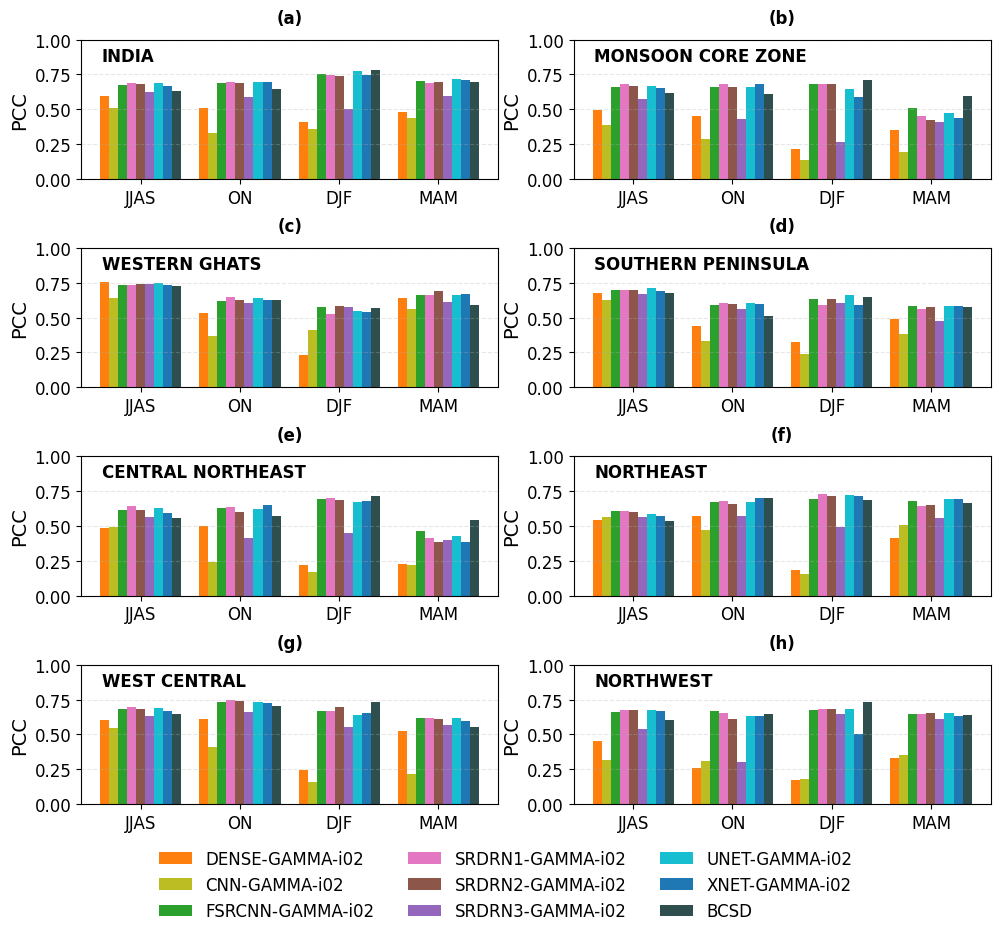

In [17]:
plot_figure_S22_26(expname="GAMMA-i02", fignum="S25", savefig=True)

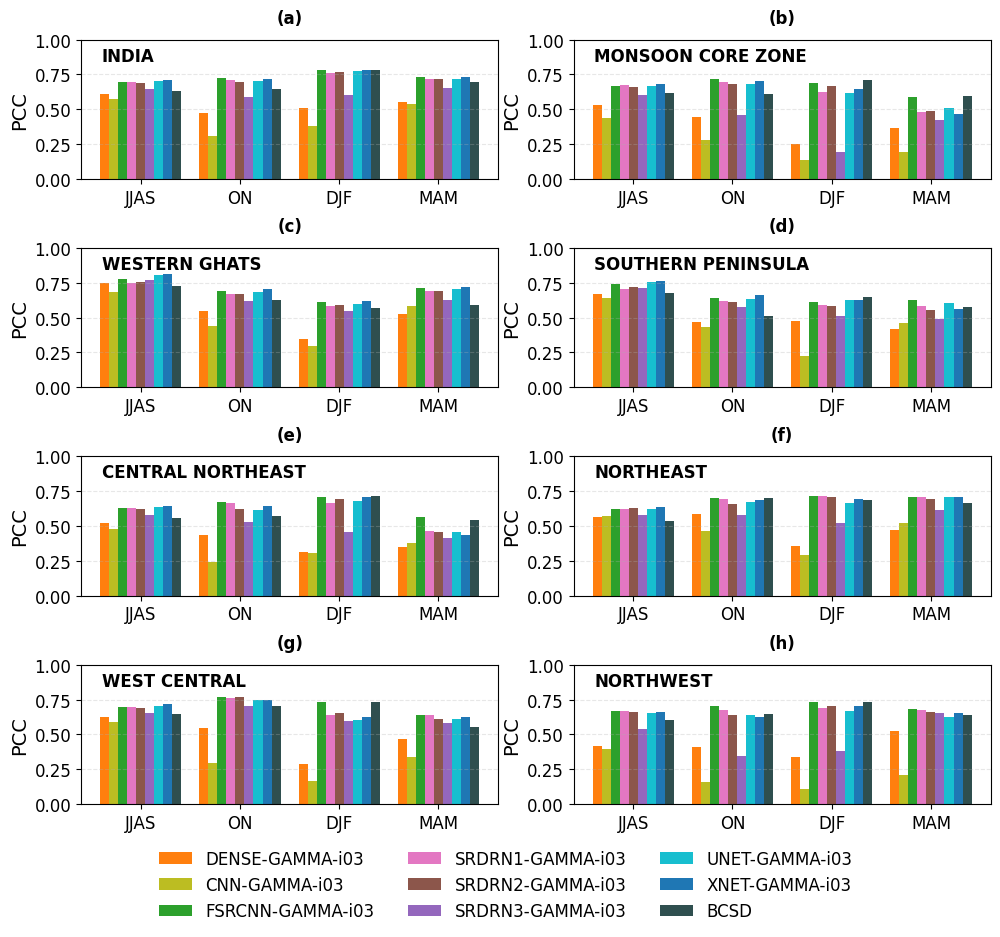

In [18]:
plot_figure_S22_26(expname="GAMMA-i03", fignum="S26", savefig=True)

# Figure S27-

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import hydroeval as he
from scipy.stats import pearsonr


def kge_only_calc(y_true, y_pred):
    evaluations = y_true[~np.isnan(y_true)].flatten()
    simulations = y_pred[~np.isnan(y_pred)].flatten()

    print(f'\ty_true flatten: {evaluations.shape}')
    print(f'\ty_pred flatten: {simulations.shape}')

    kge, pcc, alpha, beta = he.evaluator(he.kgeprime, simulations, evaluations)
    return kge[0]

def pcc_only_calc(y_true, y_pred):
    y_true = y_true[~np.isnan(y_true)].flatten()
    y_pred = y_pred[~np.isnan(y_pred)].flatten()

    pcc, pcc_pval = pearsonr(y_true, y_pred)
    return pcc

def nse_only_calc(y_true, y_pred):
    evaluations = y_true[~np.isnan(y_true)].flatten()
    simulations = y_pred[~np.isnan(y_pred)].flatten()

    nse = he.evaluator(he.nse, simulations, evaluations)
    return nse[0]

def filter_months(dataarray, filter_months_list = [6, 7, 8, 9]):
    """Filter months from an xarray dataarray"""
    return dataarray.sel(time=dataarray['time.month'].isin(filter_months_list))

def mask_array(dataarray, maskarray):
    """Mask an xarray dataarray"""
    if isinstance(maskarray, xr.DataArray):
        maskarray = maskarray.values
    if dataarray.shape[1:2] != maskarray.shape[1:2]:
        raise ValueError("dataarray and maskarray must have the same shape")
    return dataarray*maskarray

def gen_plot_data(data_dict,
                  mask_dict,
                  model_dict,
                  jjas_only=False, 
                  version='1.0.0', 
                  csv_save_path = '.',
                  metric_name = 'NSE',
                 ):

    for varname, (filepath) in data_dict.items():
        
        print(f'\nCalculating metrics for ... {varname}')
        print(f'Loading ... {filepath}')

        ds = xr.open_dataset(filepath)
        
        final_results = {}
        for (zone, (zone_mask_path, zone_name)) in mask_dict.items():

            print(f'\n\tCalculating metrics for ... {zone}: {zone_name}')
            print(f'\tLoading ... {zone_mask_path}')
        
            mask = xr.open_dataset(zone_mask_path).mask
            
            y_true = ds[f'REF_{varname}']
            if jjas_only:
                y_true = filter_months(y_true, filter_months_list = [6, 7, 8, 9])
            y_true = mask_array(y_true, mask)
            y_true = y_true.data.squeeze()
            
            regional_results = {}
            for model_id, model_name in model_dict.items():
        
                if model_id == 'REF':
                    continue
                else:
                    y_pred = ds[f'{model_id}_{varname}']
                    if jjas_only:
                        y_pred = filter_months(y_pred, filter_months_list = [6, 7, 8, 9])
                    y_pred = mask_array(y_pred, mask)
                    y_pred = y_pred.data.squeeze()

                    if metric_name=="KGE":
                        metric_value = kge_only_calc(y_true, y_pred)
                    elif metric_name=="NSE":
                        metric_value = nse_only_calc(y_true, y_pred)
                    elif metric_name=="PCC":
                        metric_value = pcc_only_calc(y_true, y_pred)
                    else:
                        print("error: CHECK CORRECT METRIC OPTIONS!")
                    
                    print(f'\tProcessing ... {model_name}: {metric_name} = {metric_value.round(4)}')
                    regional_results[model_name] = metric_value
        
            final_results[zone_name] = regional_results

        # Convert the final_results dictionary to a DataFrame
        df = pd.DataFrame(final_results)
        csv_name = f'P07A_CLIMATE_INDICES_{varname}_{metric_name}_JJAS_v{version}.csv' if jjas_only else f'P07A_CLIMATE_INDICES_{varname}_{metric_name}_v{version}.csv'
        df.to_csv(f'{csv_save_path}/{csv_name}', index_label='EXP_NAME')
        print(f"Results saved at: {csv_save_path}/{csv_name}")

##########################################################################################################################

# All Zones : All year

model_dict = {
    'REF': 'IMDAA',

    'N01_L01_I01': 'DENSE-WMAE-i01',
    'N02_L01_I01': 'CNN-WMAE-i01',
    'N03_L01_I01': 'FSRCNN-WMAE-i01',
    'S01_L01_I01': 'SRDRN1-WMAE-i01',
    'S02_L01_I01': 'SRDRN2-WMAE-i01', 
    'S03_L01_I01': 'SRDRN3-WMAE-i01', 
    'U01_L01_I01': 'UNET-WMAE-i01', 
    'U02_L01_I01': 'XNET-WMAE-i01',

    'N01_L01_I02': 'DENSE-WMAE-i02',
    'N02_L01_I02': 'CNN-WMAE-i02',
    'N03_L01_I02': 'FSRCNN-WMAE-i02',
    'S01_L01_I02': 'SRDRN1-WMAE-i02',
    'S02_L01_I02': 'SRDRN2-WMAE-i02', 
    'S03_L01_I02': 'SRDRN3-WMAE-i02', 
    'U01_L01_I02': 'UNET-WMAE-i02', 
    'U02_L01_I02': 'XNET-WMAE-i02',
    
    'N01_L01_I03': 'DENSE-WMAE-i03',
    'N02_L01_I03': 'CNN-WMAE-i03',
    'N03_L01_I03': 'FSRCNN-WMAE-i03',
    'S01_L01_I03': 'SRDRN1-WMAE-i03',
    'S02_L01_I03': 'SRDRN2-WMAE-i03', 
    'S03_L01_I03': 'SRDRN3-WMAE-i03', 
    'U01_L01_I03': 'UNET-WMAE-i03', 
    'U02_L01_I03': 'XNET-WMAE-i03',

    'N01_L02_I01': 'DENSE-GAMMA-i01',
    'N02_L02_I01': 'CNN-GAMMA-i01',
    'N03_L02_I01': 'FSRCNN-GAMMA-i01',
    'S01_L02_I01': 'SRDRN1-GAMMA-i01',
    'S02_L02_I01': 'SRDRN2-GAMMA-i01', 
    'S03_L02_I01': 'SRDRN3-GAMMA-i01', 
    'U01_L02_I01': 'UNET-GAMMA-i01', 
    'U02_L02_I01': 'XNET-GAMMA-i01',

    'N01_L02_I02': 'DENSE-GAMMA-i02',
    'N02_L02_I02': 'CNN-GAMMA-i02',
    'N03_L02_I02': 'FSRCNN-GAMMA-i02',
    'S01_L02_I02': 'SRDRN1-GAMMA-i02',
    'S02_L02_I02': 'SRDRN2-GAMMA-i02', 
    'S03_L02_I02': 'SRDRN3-GAMMA-i02', 
    'U01_L02_I02': 'UNET-GAMMA-i02', 
    'U02_L02_I02': 'XNET-GAMMA-i02',
    
    'N01_L02_I03': 'DENSE-GAMMA-i03',
    'N02_L02_I03': 'CNN-GAMMA-i03',
    'N03_L02_I03': 'FSRCNN-GAMMA-i03',
    'S01_L02_I03': 'SRDRN1-GAMMA-i03',
    'S02_L02_I03': 'SRDRN2-GAMMA-i03', 
    'S03_L02_I03': 'SRDRN3-GAMMA-i03', 
    'U01_L02_I03': 'UNET-GAMMA-i03', 
    'U02_L02_I03': 'XNET-GAMMA-i03',
    
    'C01': 'BCSD',
}

DATA_PATH = "/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/CLIMATE_INDICES.L01.I02"
data_dict = {
    'R90MON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_R90MON_v1.nc',
    'R95MON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_R95MON_v1.nc',
    'RX1DAYMON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_RX1DAYMON_v1.nc',
}

MASK_PATH = '/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/MASKFILES'
mask_dict = {
    'IND': [f'{MASK_PATH}/India.nc', 'INDIA'], 
    'MCZ': [f'{MASK_PATH}/Monsoon_Core_Zone.nc', 'MONSOON CORE ZONE'], 
    'WG' : [f'{MASK_PATH}/Western_Ghats.nc' , 'WESTERN GHATS'], 
    'SP' : [f'{MASK_PATH}/South_Peninsular.nc' , 'SOUTHERN PENINSULA'], 
    'CNE': [f'{MASK_PATH}/Central_Northeast.nc', 'CENTRAL NORTHEAST'], 
    'NE' : [f'{MASK_PATH}/Northeast.nc' , 'NORTHEAST'], 
    'WC' : [f'{MASK_PATH}/West_Central.nc' , 'WEST CENTRAL'], 
    'NW' : [f'{MASK_PATH}/Northwest.nc' , 'NORTHWEST'], 
}

SAVE_PATH = DATA_PATH

for metric in ['PCC']: # , 'NSE'
    gen_plot_data(
        data_dict,
        mask_dict,
        model_dict,
        jjas_only = False, 
        version = '1', 
        csv_save_path = SAVE_PATH,
        metric_name = metric,
    )

## Plot the RadarChart

### Prepare the data CSV

In [24]:
import numpy as np
import pandas as pd
import xarray as xr
import hydroeval as he
from scipy.stats import pearsonr


def kge_only_calc(y_true, y_pred):
    evaluations = y_true[~np.isnan(y_true)].flatten()
    simulations = y_pred[~np.isnan(y_pred)].flatten()

    print(f'\ty_true flatten: {evaluations.shape}')
    print(f'\ty_pred flatten: {simulations.shape}')

    kge, pcc, alpha, beta = he.evaluator(he.kgeprime, simulations, evaluations)
    return kge[0]

def pcc_only_calc(y_true, y_pred):
    y_true = y_true[~np.isnan(y_true)].flatten()
    y_pred = y_pred[~np.isnan(y_pred)].flatten()

    pcc, pcc_pval = pearsonr(y_true, y_pred)
    return pcc

def nse_only_calc(y_true, y_pred):
    evaluations = y_true[~np.isnan(y_true)].flatten()
    simulations = y_pred[~np.isnan(y_pred)].flatten()

    nse = he.evaluator(he.nse, simulations, evaluations)
    return nse[0]

def filter_months(dataarray, filter_months_list = [6, 7, 8, 9]):
    """Filter months from an xarray dataarray"""
    return dataarray.sel(time=dataarray['time.month'].isin(filter_months_list))

def mask_array(dataarray, maskarray):
    """Mask an xarray dataarray"""
    if isinstance(maskarray, xr.DataArray):
        maskarray = maskarray.values
    if dataarray.shape[1:2] != maskarray.shape[1:2]:
        raise ValueError("dataarray and maskarray must have the same shape")
    return dataarray*maskarray

def gen_plot_data(data_dict,
                  mask_dict,
                  model_dict,
                  jjas_only=False, 
                  version='1.0.0', 
                  csv_save_path = '.',
                  metric_name = 'NSE',
                 ):

    for varname, (filepath) in data_dict.items():
        
        print(f'\nCalculating metrics for ... {varname}')
        print(f'Loading ... {filepath}')

        ds = xr.open_dataset(filepath)
        
        final_results = {}
        for (zone, (zone_mask_path, zone_name)) in mask_dict.items():

            print(f'\n\tCalculating metrics for ... {zone}: {zone_name}')
            print(f'\tLoading ... {zone_mask_path}')
        
            mask = xr.open_dataset(zone_mask_path).mask
            
            y_true = ds[f'REF_{varname}']
            if jjas_only:
                y_true = filter_months(y_true, filter_months_list = [6, 7, 8, 9])
            y_true = mask_array(y_true, mask)
            y_true = y_true.data.squeeze()
            
            regional_results = {}
            for model_id, model_name in model_dict.items():
        
                if model_id == 'REF':
                    continue
                else:
                    y_pred = ds[f'{model_id}_{varname}']
                    if jjas_only:
                        y_pred = filter_months(y_pred, filter_months_list = [6, 7, 8, 9])
                    y_pred = mask_array(y_pred, mask)
                    y_pred = y_pred.data.squeeze()

                    if metric_name=="KGE":
                        metric_value = kge_only_calc(y_true, y_pred)
                    elif metric_name=="NSE":
                        metric_value = nse_only_calc(y_true, y_pred)
                    elif metric_name=="PCC":
                        metric_value = pcc_only_calc(y_true, y_pred)
                    else:
                        print("error: CHECK CORRECT METRIC OPTIONS!")
                    
                    print(f'\tProcessing ... {model_name}: {metric_name} = {metric_value.round(4)}')
                    regional_results[model_name] = metric_value
        
            final_results[zone_name] = regional_results

        # Convert the final_results dictionary to a DataFrame
        df = pd.DataFrame(final_results)
        csv_name = f'P07A_CLIMATE_INDICES_{varname}_{metric_name}_JJAS_v{version}.csv' if jjas_only else f'P07A_CLIMATE_INDICES_{varname}_{metric_name}_v{version}.csv'
        df.to_csv(f'{csv_save_path}/{csv_name}', index_label='EXP_NAME')
        print(f"Results saved at: {csv_save_path}/{csv_name}")

##########################################################################################################################

# All Zones : All year
calc_dict = {
    'L01.I01' : { 
        'REF': 'IMDAA',
        'N01_L01_I01': 'DENSE-WMAE-i01',
        'N02_L01_I01': 'CNN-WMAE-i01',
        'N03_L01_I01': 'FSRCNN-WMAE-i01',
        'S01_L01_I01': 'SRDRN1-WMAE-i01',
        'S02_L01_I01': 'SRDRN2-WMAE-i01', 
        'S03_L01_I01': 'SRDRN3-WMAE-i01', 
        'U01_L01_I01': 'UNET-WMAE-i01', 
        'U02_L01_I01': 'XNET-WMAE-i01',
        'C01': 'BCSD',
    },
    'L01.I02' : { 
        'REF': 'IMDAA',
        'N01_L01_I02': 'DENSE-WMAE-i02',
        'N02_L01_I02': 'CNN-WMAE-i02',
        'N03_L01_I02': 'FSRCNN-WMAE-i02',
        'S01_L01_I02': 'SRDRN1-WMAE-i02',
        'S02_L01_I02': 'SRDRN2-WMAE-i02', 
        'S03_L01_I02': 'SRDRN3-WMAE-i02', 
        'U01_L01_I02': 'UNET-WMAE-i02', 
        'U02_L01_I02': 'XNET-WMAE-i02',
        'C01': 'BCSD',
    },
    'L01.I03' : { 
        'REF': 'IMDAA',
        'N01_L01_I03': 'DENSE-WMAE-i03',
        'N02_L01_I03': 'CNN-WMAE-i03',
        'N03_L01_I03': 'FSRCNN-WMAE-i03',
        'S01_L01_I03': 'SRDRN1-WMAE-i03',
        'S02_L01_I03': 'SRDRN2-WMAE-i03', 
        'S03_L01_I03': 'SRDRN3-WMAE-i03', 
        'U01_L01_I03': 'UNET-WMAE-i03', 
        'U02_L01_I03': 'XNET-WMAE-i03',
        'C01': 'BCSD',
        },
    'L02.I01' : { 
        'REF': 'IMDAA',
        'N01_L02_I01': 'DENSE-GAMMA-i01',
        'N02_L02_I01': 'CNN-GAMMA-i01',
        'N03_L02_I01': 'FSRCNN-GAMMA-i01',
        'S01_L02_I01': 'SRDRN1-GAMMA-i01',
        'S02_L02_I01': 'SRDRN2-GAMMA-i01', 
        'S03_L02_I01': 'SRDRN3-GAMMA-i01', 
        'U01_L02_I01': 'UNET-GAMMA-i01', 
        'U02_L02_I01': 'XNET-GAMMA-i01',
        'C01': 'BCSD',
        },
    'L02.I02' : { 
        'REF': 'IMDAA',
        'N01_L02_I02': 'DENSE-GAMMA-i02',
        'N02_L02_I02': 'CNN-GAMMA-i02',
        'N03_L02_I02': 'FSRCNN-GAMMA-i02',
        'S01_L02_I02': 'SRDRN1-GAMMA-i02',
        'S02_L02_I02': 'SRDRN2-GAMMA-i02', 
        'S03_L02_I02': 'SRDRN3-GAMMA-i02', 
        'U01_L02_I02': 'UNET-GAMMA-i02', 
        'U02_L02_I02': 'XNET-GAMMA-i02',
        'C01': 'BCSD',
        },
    'L02.I03' : { 
        'REF': 'IMDAA',
        'N01_L02_I03': 'DENSE-GAMMA-i03',
        'N02_L02_I03': 'CNN-GAMMA-i03',
        'N03_L02_I03': 'FSRCNN-GAMMA-i03',
        'S01_L02_I03': 'SRDRN1-GAMMA-i03',
        'S02_L02_I03': 'SRDRN2-GAMMA-i03', 
        'S03_L02_I03': 'SRDRN3-GAMMA-i03', 
        'U01_L02_I03': 'UNET-GAMMA-i03', 
        'U02_L02_I03': 'XNET-GAMMA-i03',
        'C01': 'BCSD',
    },
}

for suffix, model_dict in calc_dict.items():

    DATA_PATH = f"/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/CLIMATE_INDICES_DATA_RADAR/CLIMATE_INDICES.{suffix}"
    data_dict = {
        'R90MON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_R90MON_v1.nc',
        'R95MON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_R95MON_v1.nc',
        'R98MON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_R98MON_v1.nc',
        'R99MON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_R99MON_v1.nc',
        'RMONMEAN': f'{DATA_PATH}/P07A_CLIMATE_INDICES_RMONMEAN_v1.nc',
        'RX1DAYMON': f'{DATA_PATH}/P07A_CLIMATE_INDICES_RX1DAYMON_v1.nc',
    }
    
    MASK_PATH = '/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/MASKFILES'
    mask_dict = {
        'IND': [f'{MASK_PATH}/India.nc', 'INDIA'], 
        'MCZ': [f'{MASK_PATH}/Monsoon_Core_Zone.nc', 'MONSOON CORE ZONE'], 
        'WG' : [f'{MASK_PATH}/Western_Ghats.nc' , 'WESTERN GHATS'], 
        'SP' : [f'{MASK_PATH}/South_Peninsular.nc' , 'SOUTHERN PENINSULA'], 
        'CNE': [f'{MASK_PATH}/Central_Northeast.nc', 'CENTRAL NORTHEAST'], 
        'NE' : [f'{MASK_PATH}/Northeast.nc' , 'NORTHEAST'], 
        'WC' : [f'{MASK_PATH}/West_Central.nc' , 'WEST CENTRAL'], 
        'NW' : [f'{MASK_PATH}/Northwest.nc' , 'NORTHWEST'], 
    }
    
    SAVE_PATH = DATA_PATH
    
    for metric in ['NSE']: # , 'PCC'
        gen_plot_data(
            data_dict,
            mask_dict,
            model_dict,
            jjas_only = False, 
            version = '1', 
            csv_save_path = SAVE_PATH,
            metric_name = metric,
        )


Calculating metrics for ... R90MON
Loading ... /home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/CLIMATE_INDICES_DATA_RADAR/CLIMATE_INDICES.L01.I01/P07A_CLIMATE_INDICES_R90MON_v1.nc

	Calculating metrics for ... IND: INDIA
	Loading ... /home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/MASKFILES/India.nc
	Processing ... DENSE-WMAE-i01: NSE = 0.7762
	Processing ... CNN-WMAE-i01: NSE = 0.789
	Processing ... FSRCNN-WMAE-i01: NSE = 0.8153
	Processing ... SRDRN1-WMAE-i01: NSE = 0.7618
	Processing ... SRDRN2-WMAE-i01: NSE = 0.7713
	Processing ... SRDRN3-WMAE-i01: NSE = 0.8065
	Processing ... UNET-WMAE-i01: NSE = 0.8094
	Processing ... XNET-WMAE-i01: NSE = 0.7952
	Processing ... BCSD: NSE = 0.7594

	Calculating metrics for ... MCZ: MONSOON CORE ZONE
	Loading ... /home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/MASKFILES/Monsoon_Core_Zone.nc
	Processing ... DENSE-WMAE-i01: NSE = 0.7972
	Processing ... CNN-WMAE-i01: NSE = 0.809
	Pr

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from matplotlib.patches import Circle


def plot_radar_plot_tab10(ax=None,
                          csv_file_path='.',
                          varname='varname',
                          label='subplot',
                          ylim=(0.5, 0.8),
                          metric_name='PCC'):
    
    zones_dict = {
        'WG': 'WESTERN GHATS',
        'MCZ': 'MONSOON CORE ZONE',
        'IND': 'INDIA',
        'NW': 'NORTHWEST',
        'CNE': 'CENTRAL NORTHEAST',
        'NE': 'NORTHEAST',
        'WC': 'WEST CENTRAL',
        'SP': 'SOUTHERN PENINSULA',
    }
    
    # Load the CSV data
    data = pd.read_csv(csv_file_path)
    
    # Get the model names from the CSV file
    model_names = data['EXP_NAME'].values # Uncomment for future use
    radar_values = {model: [] for model in model_names}
    
    # Extract metric values for each model and region
    for zone in zones_dict.keys():
        for i, model in enumerate(model_names):
            radar_values[model].append(data[zones_dict[zone]].values[i])
    
    # Create DataFrame for the radar chart
    radar_data = pd.DataFrame(radar_values, index=zones_dict.keys())
    
    # Number of variables (regions) we're plotting
    num_vars = len(zones_dict)
    
    # Compute the angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    colors = [
        
        "#ff7f0e",  # Orange pair
        "#bcbd22",  # Yellow-green pair
        "#2ca02c",  # Green pair
        "#e377c2",  # Pink pair
        "#8c564b",  # Brown pair
        "#9467bd",  # Purple pair
        "#17becf",  # Teal pair
        "#1f77b4",  # Blue pair
        "#2F4F4F",
    ]
    
    # Store handles and labels for legend
    handles = []
    labels = []
    
    # Plot each model
    for i, model in enumerate(model_names): 
        if model in radar_data.columns:
            values = radar_data[model].tolist()
            values += values[:1]
            line, = ax.plot(angles, values, linewidth=2, linestyle='-', marker='o', markersize=10, label=model,
                            color=colors[i % len(model_names)])
            ax.fill(angles, values, alpha=0, color=colors[i % len(model_names)])
            handles.append(line)  # Add line handle to the legend list
            labels.append(model)  # Add model name to the legend labels list
        else:
            print(f"Warning: Model '{model}' not found in radar_data columns.")
    
    # Set xlabels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(zones_dict.keys()), fontsize=15, fontweight='bold')
    
    # Set ylabels
    ax.set_ylim(ylim[0], ylim[1])
    y_ticks = np.arange(ylim[0], ylim[1] + 0.1, 0.1)  # 0.1 increments
    ax.set_yticks(y_ticks[1:-1])

    # Hide default y-tick labels
    ax.set_yticklabels([])

    # Add y-tick labels manually with a high zorder
    for tick in y_ticks[1:-1]:
        ax.text(np.pi / 9, tick, f'{tick:.1f}', ha='center', fontsize=12, fontweight='bold', color='black', zorder=12) 
    
    # Create a white circle at the center
    circle = Circle((0.5, 0.5), 0.07, color='white', ec='black', lw=2, transform=ax.transAxes, zorder=10)
    ax.add_patch(circle)
    
    # Add the metric name on top of the circle
    ax.text(0.5, 0.5, metric_name, ha='center', va='center', color='grey', fontsize=14, fontweight='semibold', transform=ax.transAxes, zorder=11)

    # Add label at the top right of the plot
    ax.text(0.75, 1.01, label, transform=ax.transAxes, ha='center', fontsize=16, fontweight='bold',
            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))

    return handles, labels  # Return handles and labels for legend

######################################################################################################################################

def plotfigure_s27_31(varname_dict, suffix, metric_name, fignum, savefig = True):


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw=dict(polar=True))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    

    
    DATA_PATH = f"/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/CLIMATE_INDICES_DATA_RADAR/CLIMATE_INDICES.{suffix}" # Edit here
    
    # Get model names and plot handles for the legend
    handles_list = []
    labels_list = []
    for i, (ax, (varname, (varlabel, ylim))) in enumerate(zip(axs.flat, varname_dict.items())):
        csv_file_path = f"{DATA_PATH}/P07A_CLIMATE_INDICES_{varname}_{metric_name}_v1.csv"
        handles, labels = plot_radar_plot_tab10(ax=ax, csv_file_path=csv_file_path, varname=varname, ylim=ylim, label=varlabel)
        handles_list.extend(handles)
        labels_list.extend(labels)
        ax.text(0.04, 1.1, f"({chr(97 + i)})", transform=ax.transAxes, fontsize=30, color='k', fontweight='normal')
    
    # Create a common legend using the handles and labels from the first subplot
    fig.legend(handles=handles_list[:9], labels=labels_list[:9], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=18, frameon=False)
    
    # Save and show plot
    if savefig:
        SAVE_PATH = "/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/RESULTS"
        plt.savefig(f'{SAVE_PATH}/Figure{fignum}_RadarPlot_ExtremeIndices_{metric_name}_1.png', 
                    format='png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='w')
    
    plt.show()


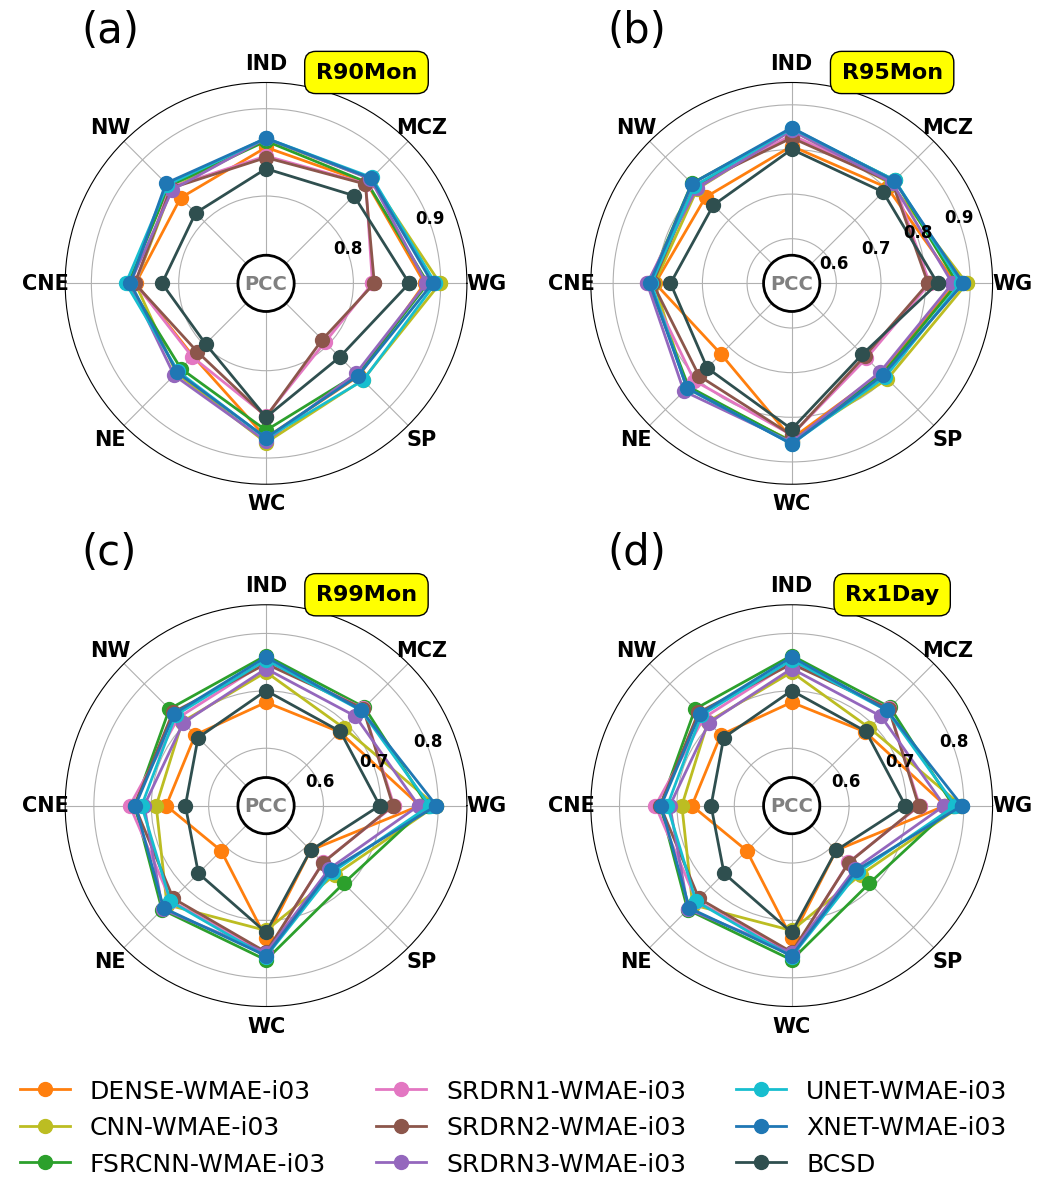

In [3]:
varname_dict = {
        "R90MON": ["R90Mon", (0.75, 0.98)],
        "R95MON": ["R95Mon", (0.5, 0.95)],
        "R99MON": ["R99Mon", (0.5, 0.85)],
        "RX1DAYMON": ["Rx1Day", (0.5, 0.85)],
    }

plotfigure_s27_31(varname_dict, suffix='L01.I03', metric_name='PCC', fignum='07', savefig = True)

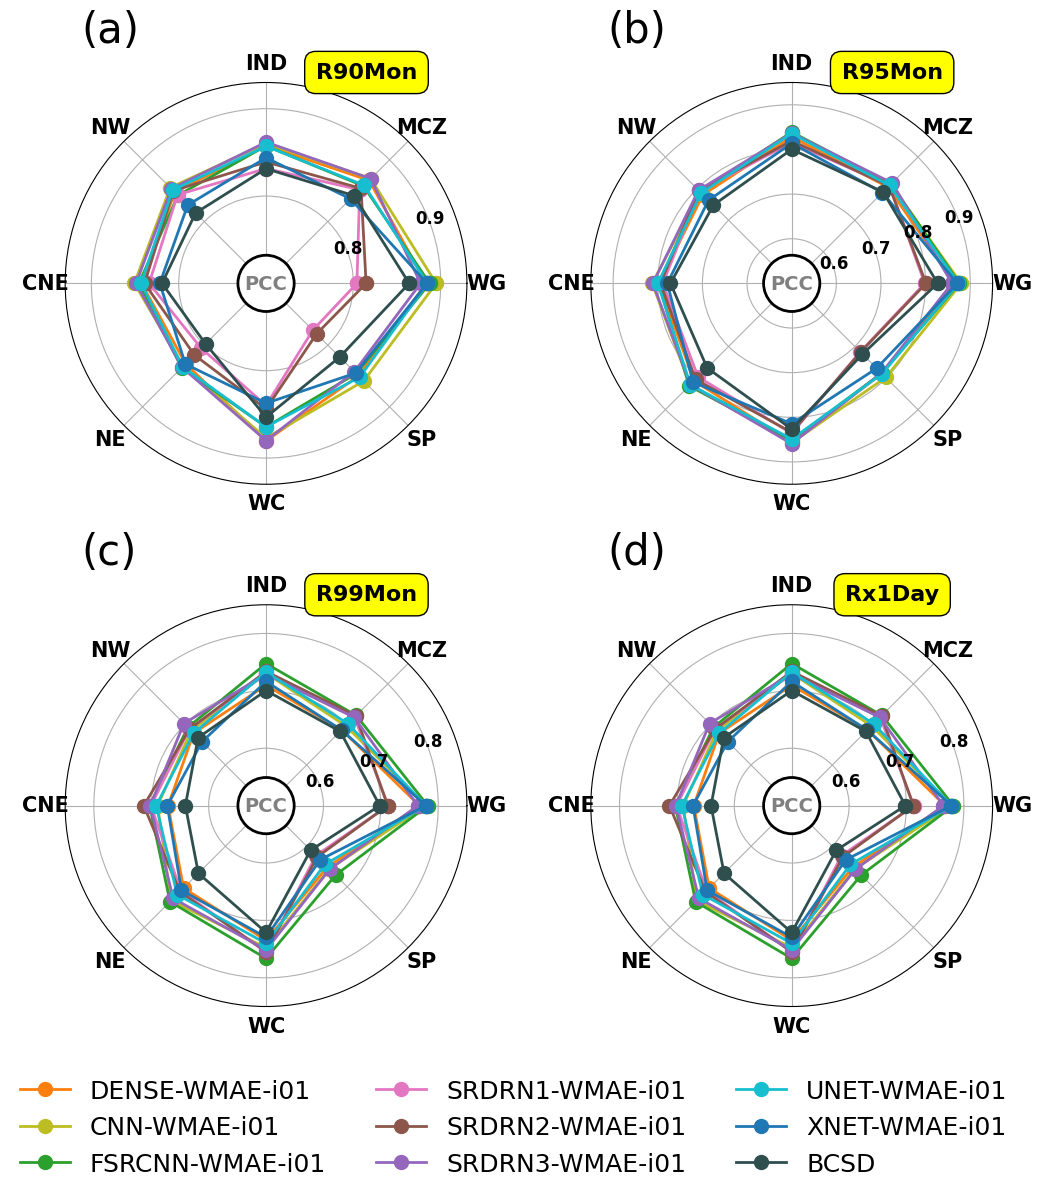

In [2]:
varname_dict = {
        "R90MON": ["R90Mon", (0.75, 0.98)],
        "R95MON": ["R95Mon", (0.5, 0.95)],
        "R99MON": ["R99Mon", (0.5, 0.85)],
        "RX1DAYMON": ["Rx1Day", (0.5, 0.85)],
    }

plotfigure_s27_31(varname_dict, suffix='L01.I01', metric_name='PCC', fignum='S27', savefig = True)

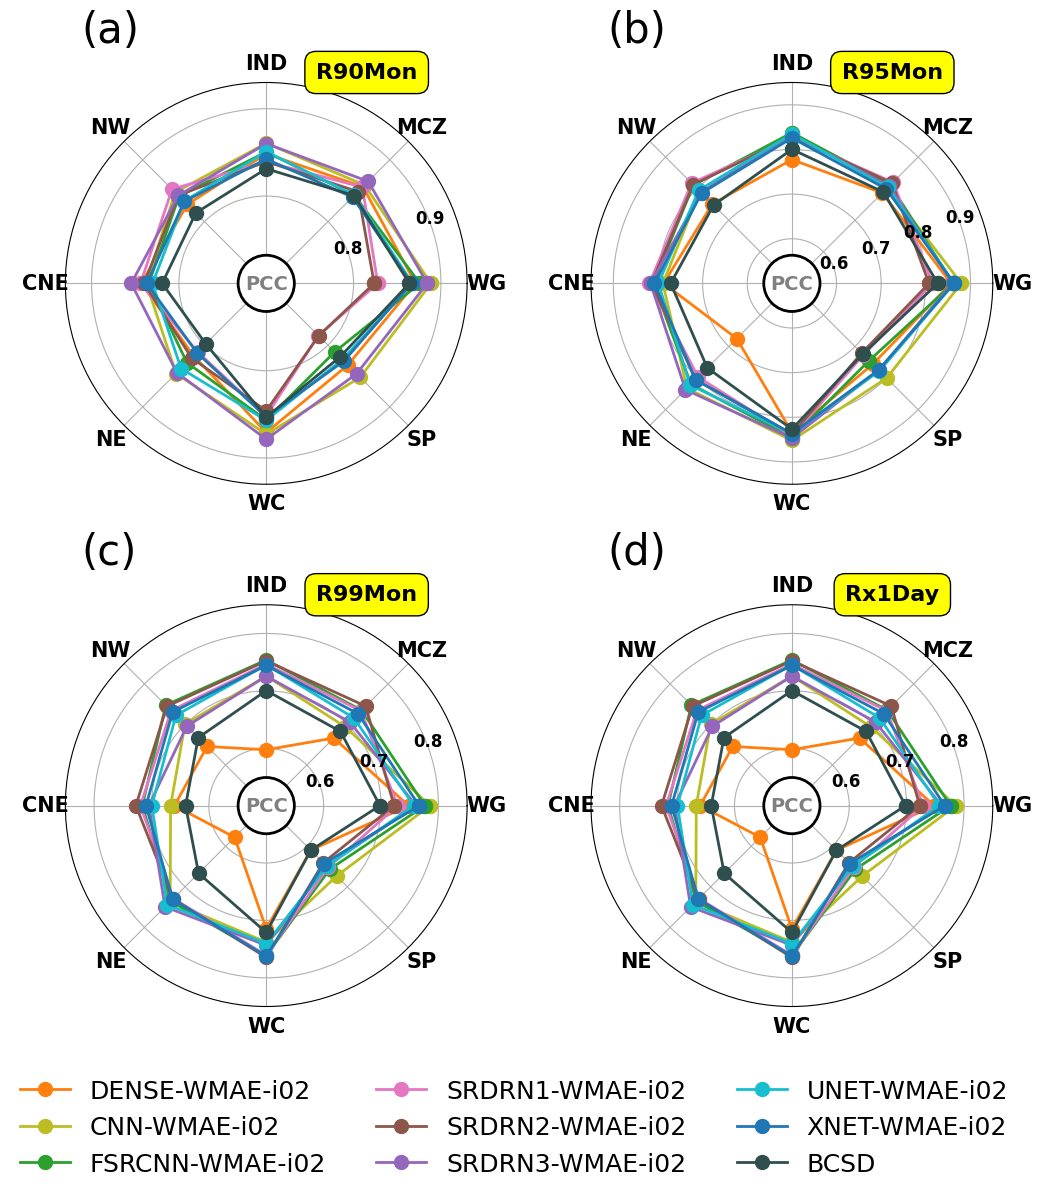

In [79]:
varname_dict = {
        "R90MON": ["R90Mon", (0.75, 0.98)],
        "R95MON": ["R95Mon", (0.5, 0.95)],
        "R99MON": ["R99Mon", (0.5, 0.85)],
        "RX1DAYMON": ["Rx1Day", (0.5, 0.85)],
    }

plotfigure_s27_31(varname_dict, suffix='L01.I02', metric_name='PCC', fignum='S28', savefig = True)

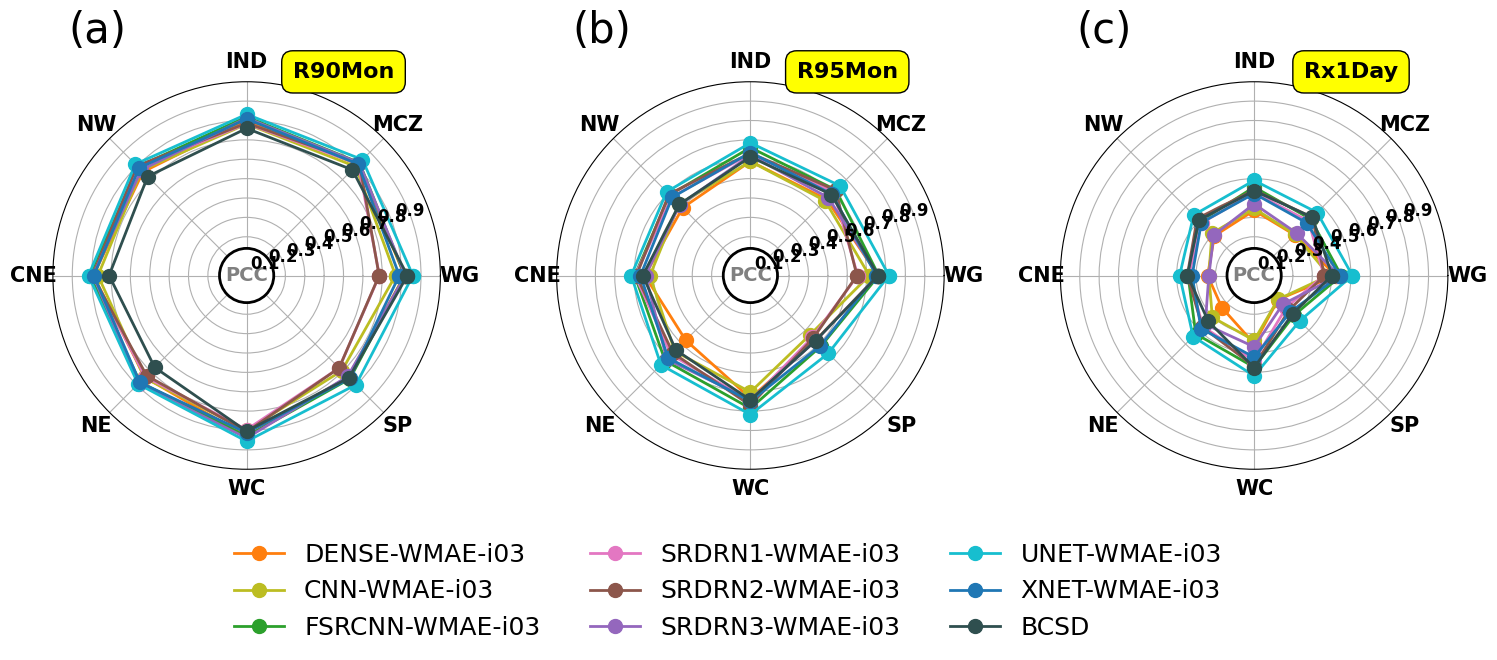

In [63]:
# varname_dict = {
#         "R90MON": ["R90Mon", (0, 1)],
#         "R95MON": ["R95Mon", (0, 1)],
#         "RX1DAYMON": ["Rx1Day", (0, 1)],
#     }

# plotfigure_s27_31(varname_dict, suffix='L01.I03', metric_name='NSE', fignum='XX', savefig = True)

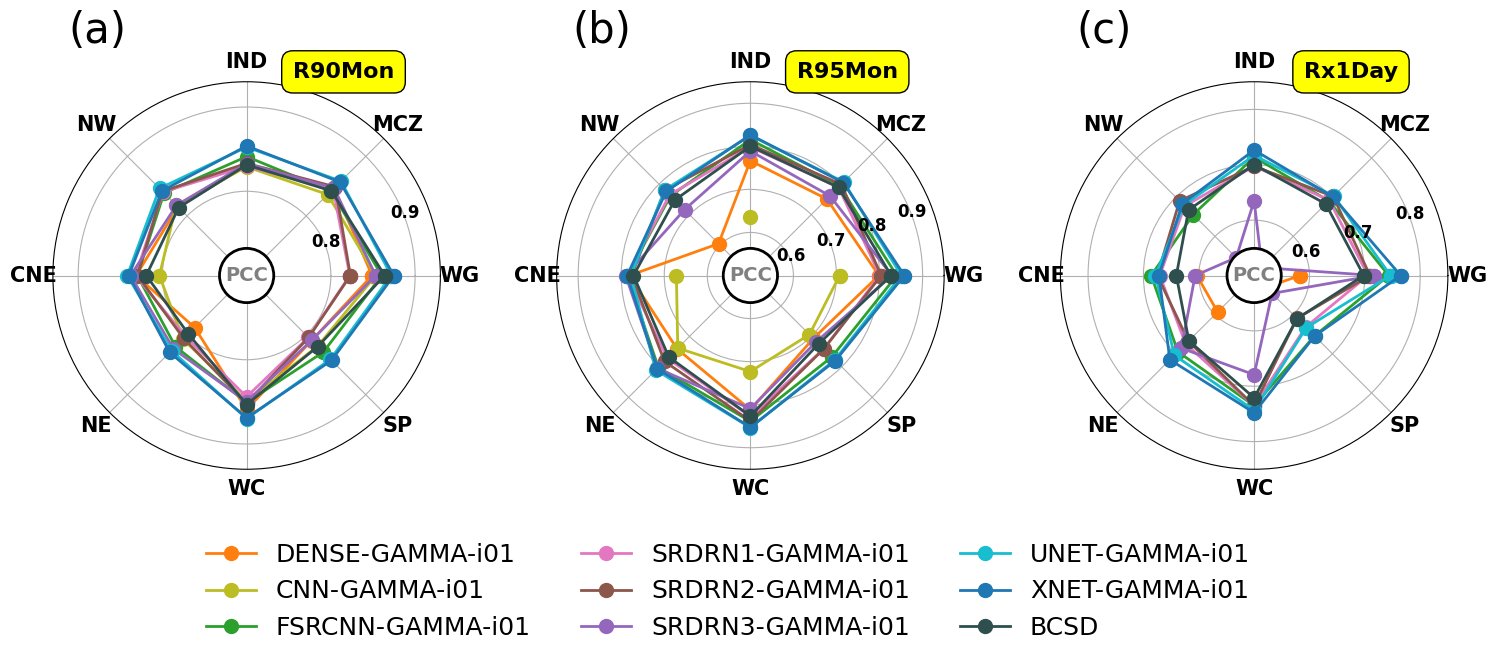

In [64]:
varname_dict = {
        "R90MON": ["R90Mon", (0.75, 0.98)],
        "R95MON": ["R95Mon", (0.5, 0.95)],
        "RX1DAYMON": ["Rx1Day", (0.5, 0.85)],
    }

plotfigure_s27_31(varname_dict, suffix='L02.I01', metric_name='PCC', fignum='S29', savefig = True)

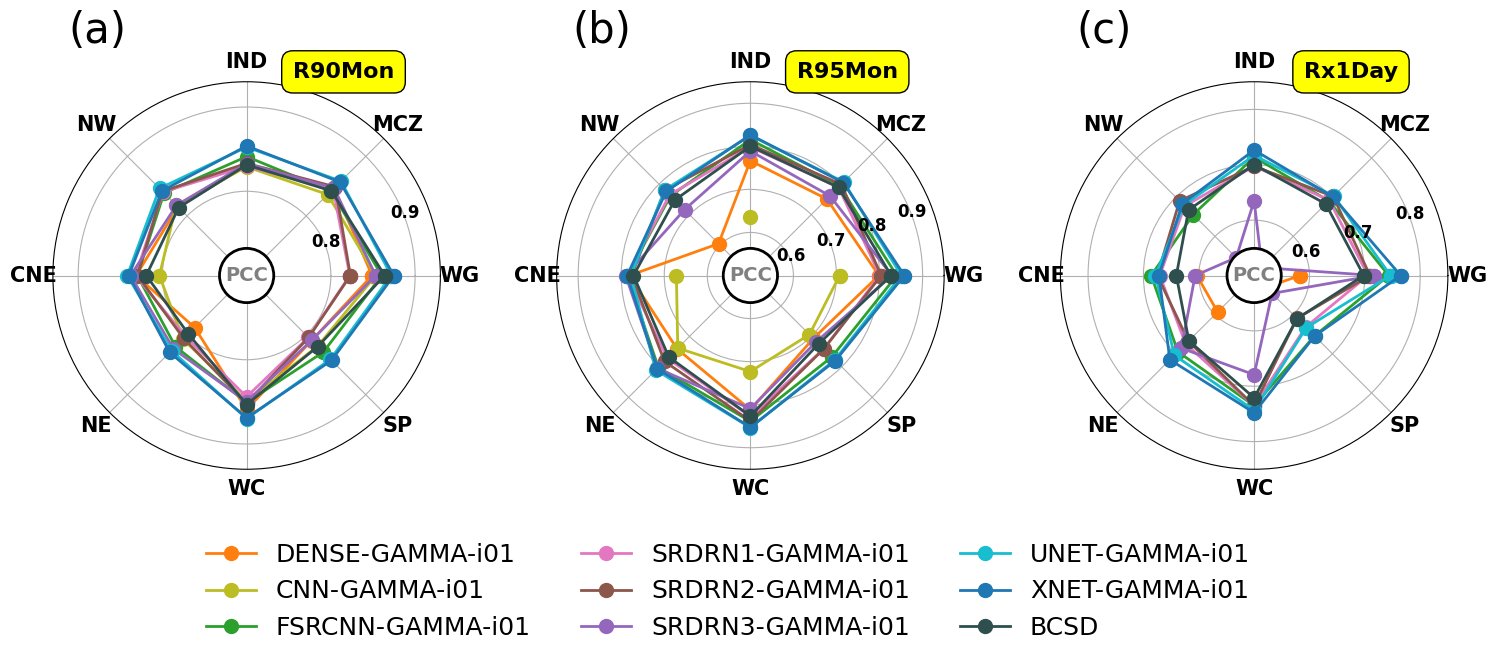

In [65]:
varname_dict = {
        "R90MON": ["R90Mon", (0.75, 0.98)],
        "R95MON": ["R95Mon", (0.5, 0.95)],
        "RX1DAYMON": ["Rx1Day", (0.5, 0.85)],
    }

plotfigure_s27_31(varname_dict, suffix='L02.I01', metric_name='PCC', fignum='S29', savefig = True)

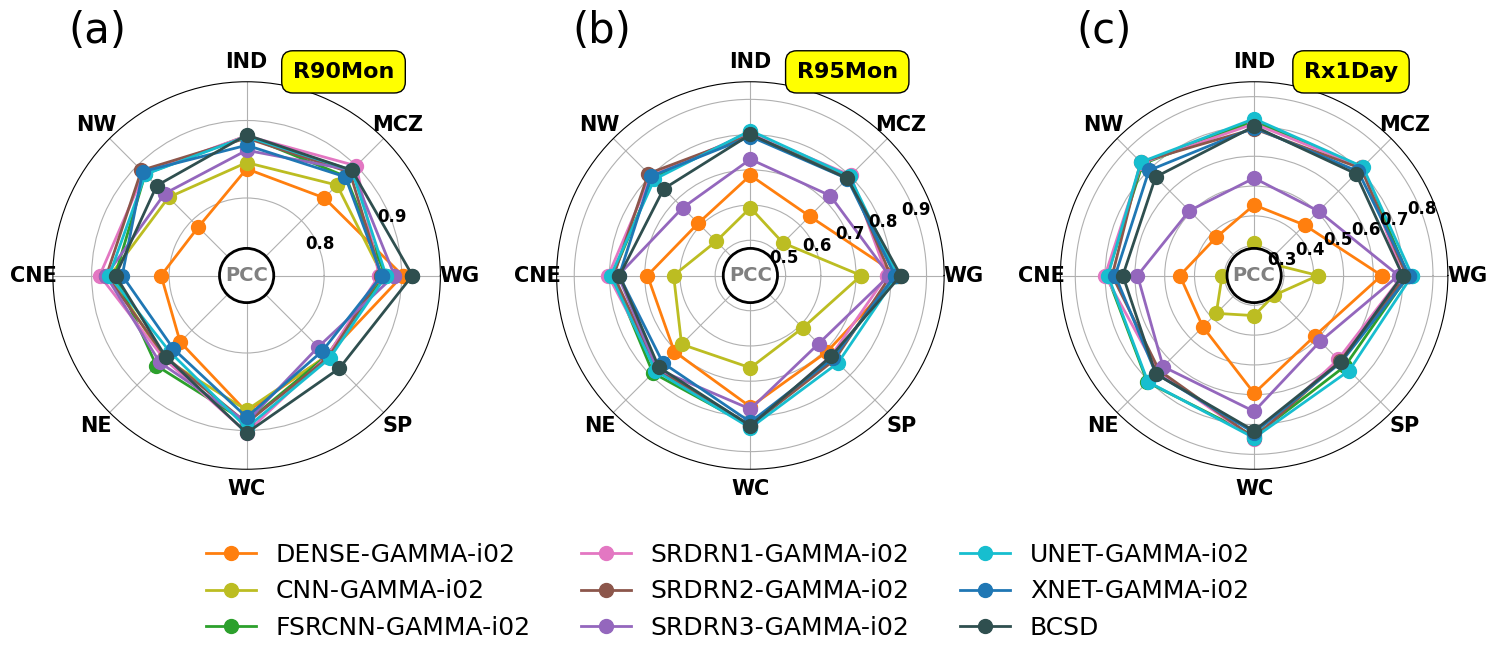

In [72]:
varname_dict = {
        "R90MON": ["R90Mon", (0.7, 0.95)],
        "R95MON": ["R95Mon", (0.4, 0.95)],
        "R99MON": ["R99Mon", (0.2, 0.85)],
        "RX1DAYMON": ["Rx1Day", (0.2, 0.85)],
    }

plotfigure_s27_31(varname_dict, suffix='L02.I02', metric_name='PCC', fignum='S30', savefig = True)

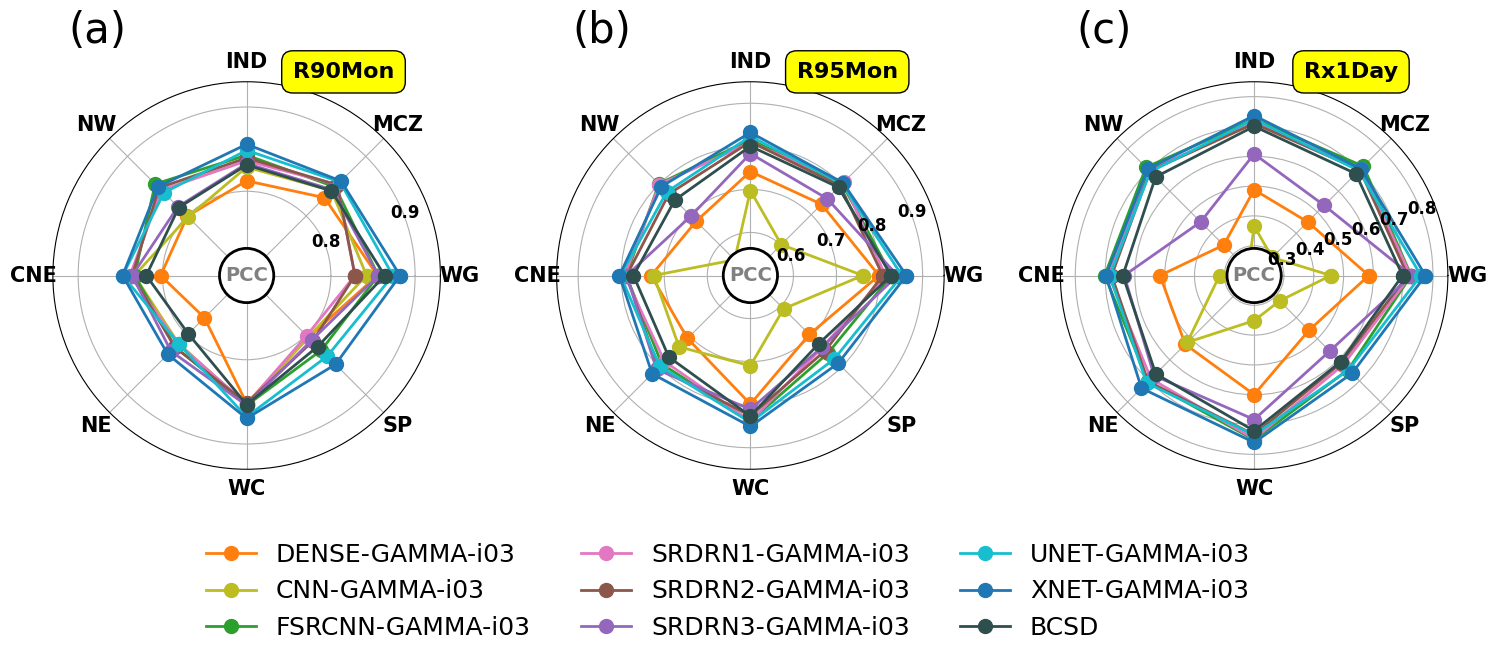

In [67]:
varname_dict = {
        "R90MON": ["R90Mon", (0.75, 0.98)],
        "R95MON": ["R95Mon", (0.5, 0.95)],
        "RX1DAYMON": ["Rx1Day", (0.2, 0.85)],
    }

plotfigure_s27_31(varname_dict, suffix='L02.I03', metric_name='PCC', fignum='S31', savefig = True)